In [1]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from haversine import haversine
import plotly.express as px
from keplergl import KeplerGl
import community as community_louvain

import geopandas as gpd

import networkx as nx
from pyvis.network import Network
from shapely.geometry import Point
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib
# see all columns
pd.set_option('display.max_columns', None)
# set seaborn style
sns.set_style('white')
# set context to notebook
sns.set_context('notebook')

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
dr_trips = pd.read_csv('../data/processed/dr_trips_oneway_cleaned_zone.csv')
car_trips = pd.read_csv('../data/processed/car_trips_cleaned_zones.csv')
#daily_weather = pd.read_csv('../data/processed/daily_weather.csv')  

In [3]:
rename_mapping = {'latitudeStart': 'LatitudeStart','latitudeEnd': 'LatitudeEnd', 'longitudeEnd':'LongitudeEnd', 'longitudeStart': 'LongitudeStart', 'SpeedKmHrHav': 'SpeedKmHr',
                  "HaversineDistance": 'DistanceKm'}
dr_trips.rename(columns=rename_mapping, inplace=True)

In [4]:
dr_trips.columns

Index(['StartTime', 'EndTime', 'UserId', 'LatitudeStart', 'LongitudeStart',
       'nameStart', 'LatitudeEnd', 'LongitudeEnd', 'nameEnd',
       'StartHubClusterId', 'EndHubClusterId', 'StartClusterName',
       'EndClusterName', 'StartClusterLatitude', 'StartClusterLongitude',
       'EndClusterLatitude', 'EndClusterLongitude', 'DistanceKm', 'Month',
       'StartHour', 'Weekday', 'TripDurationMin', 'TripDurationHr',
       'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth', 'DurationGroup',
       'StartTimeUpdated', 'TotalDurationMin', 'TripDistanceKm',
       'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes',
       'PickupStationProximity', 'DropoffStationProximity', 'SpeedKmHr',
       'SpeedKmHrP', 'DistanceType', 'UserCategory', 'UserCluster', 'DayType',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'StartZoneCounts', 'EndZoneCounts',
       'TripDurationDiff'],
      dtype='object')

In [5]:
car_trips.columns

Index(['PersonID', 'LatitudeStart', 'LongitudeStart', 'LatitudeEnd',
       'LongitudeEnd', 'StartTime', 'EndTime', 'Age', 'Gender', 'KmDriven',
       'TripDurationHours', 'TripDurationMinutes', 'Month', 'Weekday',
       'StartHour', 'HaversineDistance', 'StartTimeUpdated',
       'TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin',
       'TotalTransitTimeMin', 'Changes', 'PickupStationProximity',
       'DropoffStationProximity', 'CarDurationMin', 'CarDistanceKm', 'source',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'RoundTrip', 'AvgSpeed',
       'TripDurationDiff', 'TripDurationDiffProcent', 'CarsDiffTime',
       'StartZoneCounts', 'EndZoneCounts'],
      dtype='object')

In [6]:
# in car_trips, rename 'TripDurationMinutes' to 'TripDurationMin', AvgSpeed to SpeedKmHr,

rename_mapping = {'TripDurationMinutes': 'TripDurationMin', 'AvgSpeed': 'SpeedKmHr', 'PersonID': 'UserId',
                  "KmDriven": 'DistanceKm'}
car_trips.rename(columns=rename_mapping, inplace=True)


In [7]:
# Count the number of users who have above 40 trips 
#car_trips = car_trips[car_trips['source'] == 'sharenow']
between_50_and_100_trips = ((car_trips['UserId'].value_counts() >= 40)).sum()

# Count the number of users who have between 10 and 40 trips
between_10_and_50_trips = ((car_trips['UserId'].value_counts() >= 10) & (car_trips['UserId'].value_counts() < 40)).sum()

# Count the number of users who have below 10 trips
below_10_trips = (car_trips['UserId'].value_counts() < 10).sum()
print(f"Users with above 40: {between_50_and_100_trips}")
print(f"Users with between 10 and 40 trips: {between_10_and_50_trips}")
print(f"Users with below 10 trips: {below_10_trips}")

Users with above 40: 1587
Users with between 10 and 40 trips: 5013
Users with below 10 trips: 97804


In [8]:
# Step 1: Calculate total trips per user and map it back to each row in the DataFrame
# This creates a Series where the index is the UserId from the original DataFrame, and the value is the count of trips per user
trip_counts = car_trips['UserId'].map(car_trips['UserId'].value_counts())

# Step 2: Define conditions and labels for binning directly on the trips DataFrame
conditions = [
    (trip_counts < 10),
    (trip_counts >= 10) & (trip_counts <= 39),
    (trip_counts >= 40)
]
labels = ['Occasional Users', 'Moderately Active Users', 'Active Users']

# Step 3: Use np.select to create the 'UserCategory' column based on these conditions
car_trips['UserCategory'] = np.select(conditions, labels, default='Unknown')
# CONVERT TO CATEGORY
car_trips['UserCategory'] = car_trips['UserCategory'].astype('category')

In [9]:
car_trips['UserCategory'].value_counts()

UserCategory
Occasional Users           136193
Active Users               130549
Moderately Active Users     95959
Name: count, dtype: int64

In [10]:
# print the set of columns intersecting both dataframes
common_cols= set(dr_trips.columns) & set(car_trips.columns)

In [11]:
common_cols 

{'Changes',
 'DistanceKm',
 'DropoffStationProximity',
 'EndTime',
 'EndZoneCounts',
 'EndZoneDescri',
 'EndZoneId',
 'EndZoneName',
 'LatitudeEnd',
 'LatitudeStart',
 'LongitudeEnd',
 'LongitudeStart',
 'Month',
 'PickupStationProximity',
 'RoundTrip',
 'SpeedKmHr',
 'StartHour',
 'StartTime',
 'StartTimeUpdated',
 'StartZoneCounts',
 'StartZoneDescri',
 'StartZoneId',
 'StartZoneName',
 'TotalDurationMin',
 'TotalTransitTimeMin',
 'TotalWalkingTimeMin',
 'TripDistanceKm',
 'TripDurationDiff',
 'TripDurationMin',
 'UserCategory',
 'UserId',
 'Weekday'}

In [12]:
# drop the columns that are not in the common_cols set
dr_trips.drop(columns=dr_trips.columns.difference(common_cols), inplace=True)
car_trips.drop(columns=car_trips.columns.difference(common_cols), inplace=True)


In [13]:
car_trips.columns

Index(['UserId', 'LatitudeStart', 'LongitudeStart', 'LatitudeEnd',
       'LongitudeEnd', 'StartTime', 'EndTime', 'DistanceKm', 'TripDurationMin',
       'Month', 'Weekday', 'StartHour', 'StartTimeUpdated', 'TotalDurationMin',
       'TripDistanceKm', 'TotalWalkingTimeMin', 'TotalTransitTimeMin',
       'Changes', 'PickupStationProximity', 'DropoffStationProximity',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'RoundTrip', 'SpeedKmHr',
       'TripDurationDiff', 'StartZoneCounts', 'EndZoneCounts', 'UserCategory'],
      dtype='object')

In [14]:
# remove duplicate columns from dr_trips
dr_trips = dr_trips.loc[:,~dr_trips.columns.duplicated()]

In [15]:
dr_trips.columns

Index(['StartTime', 'EndTime', 'UserId', 'LatitudeStart', 'LongitudeStart',
       'LatitudeEnd', 'LongitudeEnd', 'DistanceKm', 'Month', 'StartHour',
       'Weekday', 'TripDurationMin', 'SpeedKmHr', 'RoundTrip',
       'StartTimeUpdated', 'TotalDurationMin', 'TripDistanceKm',
       'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes',
       'PickupStationProximity', 'DropoffStationProximity', 'UserCategory',
       'StartZoneId', 'StartZoneName', 'StartZoneDescri', 'EndZoneId',
       'EndZoneName', 'EndZoneDescri', 'StartZoneCounts', 'EndZoneCounts',
       'TripDurationDiff'],
      dtype='object')

In [16]:
# check dr_trips StartTime range
dr_trips['StartTime'].min(), dr_trips['StartTime'].max()

('2018-03-01 16:26:42.857427', '2019-04-02 12:25:08.815354')

In [17]:
# add column "Mode" to dr_trips to indicate the mode: bike
dr_trips['Mode'] = 'bike'
# add column "Mode" to car_trips to indicate the mode: car
car_trips['Mode'] = 'car'

In [18]:
# rearanage the columns to match the order of the dr_trips
car_trips = car_trips[dr_trips.columns]


In [19]:
car_trips['StartTime'].min(), car_trips['StartTime'].max()

('2017-07-01 00:13:04', '2018-05-08 23:36:00')

In [20]:
# stack the two dataframes on top of each other
all_trips = pd.concat([dr_trips, car_trips], axis=0)


In [21]:
# drop UserId column
all_trips = all_trips.drop(columns=["RoundTrip", "StartTimeUpdated"])


In [22]:
all_trips.columns

Index(['StartTime', 'EndTime', 'UserId', 'LatitudeStart', 'LongitudeStart',
       'LatitudeEnd', 'LongitudeEnd', 'DistanceKm', 'Month', 'StartHour',
       'Weekday', 'TripDurationMin', 'SpeedKmHr', 'TotalDurationMin',
       'TripDistanceKm', 'TotalWalkingTimeMin', 'TotalTransitTimeMin',
       'Changes', 'PickupStationProximity', 'DropoffStationProximity',
       'UserCategory', 'StartZoneId', 'StartZoneName', 'StartZoneDescri',
       'EndZoneId', 'EndZoneName', 'EndZoneDescri', 'StartZoneCounts',
       'EndZoneCounts', 'TripDurationDiff', 'Mode'],
      dtype='object')

In [23]:
# rename the 'TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes', 'PickupStationProximity to add PubT prefix but remove Trip or total 
rename_mapping = {'TotalDurationMin': 'PubTDurationMin', 'TripDistanceKm': 'PubTDistanceKm', 'TotalWalkingTimeMin': 'PubTWalkingTimeMin', 'TotalTransitTimeMin': 'PubTTransitTimeMin', 'Changes': 'PubTChanges'}
all_trips.rename(columns=rename_mapping, inplace=True)

In [24]:
# convert StartTime and EndTime to datetime
all_trips['StartTime'] = pd.to_datetime(all_trips['StartTime'], format='mixed')
all_trips['StartTime'] = all_trips['StartTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
all_trips['StartTime'] = pd.to_datetime(all_trips['StartTime'])
all_trips['EndTime'] = pd.to_datetime(all_trips['EndTime'], format='mixed')
all_trips['EndTime'] = all_trips['EndTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
all_trips['EndTime'] = pd.to_datetime(all_trips['EndTime'])
# create a new col TripDurationDifference where we subtract PubTDurationMin from TripDurationMin
all_trips['TripDurationDifference'] = all_trips['PubTDurationMin'] - all_trips['TripDurationMin']

In [25]:
# sort the dataset by StartTime
all_trips = all_trips.sort_values(by='StartTime').reset_index(drop=True)

In [26]:
all_trips.columns

Index(['StartTime', 'EndTime', 'UserId', 'LatitudeStart', 'LongitudeStart',
       'LatitudeEnd', 'LongitudeEnd', 'DistanceKm', 'Month', 'StartHour',
       'Weekday', 'TripDurationMin', 'SpeedKmHr', 'PubTDurationMin',
       'PubTDistanceKm', 'PubTWalkingTimeMin', 'PubTTransitTimeMin',
       'PubTChanges', 'PickupStationProximity', 'DropoffStationProximity',
       'UserCategory', 'StartZoneId', 'StartZoneName', 'StartZoneDescri',
       'EndZoneId', 'EndZoneName', 'EndZoneDescri', 'StartZoneCounts',
       'EndZoneCounts', 'TripDurationDiff', 'Mode', 'TripDurationDifference'],
      dtype='object')

In [27]:
# save all_trips to a csv file
#all_trips.to_csv('../data/processed/all_trips_cars_bikes.csv', index=False)

Edges will represent trips between zones. The simplest approach is to iterate through the dataset and add an edge for each trip. However, to avoid adding an edge for each row and instead aggregate trips, you could calculate the average or total statistics for trips between each pair of zones.

In [28]:
# count nr of StartZoneName and EndZoneName
all_trips['StartZoneName'].nunique(), all_trips['EndZoneName'].nunique()

(320, 323)

In [29]:
296*302

89392

In [30]:
bike_df = all_trips.query('Mode == "bike"')
car_df = all_trips.query('Mode == "car"')

In [31]:
# save car_df to csv 
#car_df.to_csv('../data/processed/car_trips.csv', index=False)


In [32]:
car_df.SpeedKmHr.max()

123.48284960422168

In [33]:
# import cph_cars.shp
cph_cars = gpd.read_file('../data/processed/cph_cars.shp')
# import cph_bikes.shp
cph_bikes = gpd.read_file('../data/processed/cph_bikes.shp')

In [34]:
def check_zones(sph_df, df):
    # get the set of values in the StartZoneName and EndZoneName columns
    start_zones = set(df['StartZoneName'])
    end_zones = set(df['EndZoneName'])

    # get the set of values in the StartZoneName and EndZoneName columns all together
    all_zones = start_zones.union(end_zones)
    
    # find the names of zones that are in all_zones but not in sph_df['zonenavn']
    missing_zones = all_zones - set(sph_df['zonenavn'])
    
    # drop the rows in df where StartZoneName or EndZoneName is in missing_zones
    df = df[~df['StartZoneName'].isin(missing_zones)]
    df = df[~df['EndZoneName'].isin(missing_zones)]
    
    return df


In [35]:
bike_df = check_zones(cph_bikes, bike_df)
car_df = check_zones(cph_cars, car_df)


In [36]:
# compute the correlation between PubChanges and TripDuratioNDifference
car_df[['PubTChanges','TripDurationDifference']].corr()

PubTChanges  TripDurationDifference
PubTChanges                  1.0000                  0.1983
TripDurationDifference       0.1983                  1.0000

In [37]:
# in bike_df print all rows where StartZoneName or EndZoneName is Hellerup NØ
bike_df.query('StartZoneName == "Hellerup NØ" or EndZoneName == "Hellerup NØ"')

Empty DataFrame
Columns: [StartTime, EndTime, UserId, LatitudeStart, LongitudeStart, LatitudeEnd, LongitudeEnd, DistanceKm, Month, StartHour, Weekday, TripDurationMin, SpeedKmHr, PubTDurationMin, PubTDistanceKm, PubTWalkingTimeMin, PubTTransitTimeMin, PubTChanges, PickupStationProximity, DropoffStationProximity, UserCategory, StartZoneId, StartZoneName, StartZoneDescri, EndZoneId, EndZoneName, EndZoneDescri, StartZoneCounts, EndZoneCounts, TripDurationDiff, Mode, TripDurationDifference]
Index: []

In [38]:
edge_data_bike = bike_df.groupby(['StartZoneName', 'EndZoneName']).agg(
    AverageTripDurationMin=('TripDurationMin', 'mean'),
    TotalTrips=('TripDurationMin', 'count'),
    AvgDistanceKm=('DistanceKm', 'mean'),
    AverageSpeedKmHr=('SpeedKmHr', 'mean'),
    PubTAverageDurationMin=('PubTDurationMin', 'mean'),
    PubTAverageDistanceKm=('PubTDistanceKm', 'mean'),
    PubTAverageWalkingTimeMin=('PubTWalkingTimeMin', 'mean'),
    PubTAverageTransitTimeMin=('PubTTransitTimeMin', 'mean'),
    PubTAverageChanges=('PubTChanges', 'mean'),
    AvgTripDurationDifference=('TripDurationDifference', 'mean'),
    PickupStationProximity=('PickupStationProximity', 'mean'),
    DropoffStationProximity=('DropoffStationProximity', 'mean')
).reset_index()

In [39]:
edge_data_bike.head()

StartZoneName          EndZoneName  AverageTripDurationMin  \
0  Amager Fælled nord  Amager Strandpark N               21.769504   
1  Amager Fælled nord           Amagertorv               18.533285   
2  Amager Fælled nord         Amagerværket               46.506974   
3  Amager Fælled nord        Amalienborg Ø               25.517634   
4  Amager Fælled nord      Bella Centret V               20.663591   

   TotalTrips  AvgDistanceKm  AverageSpeedKmHr  PubTAverageDurationMin  \
0           2       4.228218          8.544064               37.000000   
1          36       2.137185         10.711721               28.073148   
2           1       3.984560          3.999400               40.266667   
3           6       2.871032          7.725212               34.327778   
4           4       2.856438          9.174718               23.750000   

   PubTAverageDistanceKm  PubTAverageWalkingTimeMin  \
0               5.749420                  23.166667   
1               3.933080                  19.692593   
2               5.226230                  11.150000   
3               3.875563                  20.488889   
4               4.255805                  15.491667   

   PubTAverageTransitTimeMin  PubTAverageChanges  AvgTripDurationDifference  \
0                   9.833333            0.000000                  15.230496   
1                   7.777778            0.083333                   9.539863   
2                  23.000000            1.000000                  -6.240307   
3                  12.833333            0.166667                   8.810144   
4                   7.250000            0.250000                   3.086409   

   PickupStationProximity  DropoffStationProximity  
0              694.030000               826.620000  
1              571.471667               743.123889  
2              310.530000               207.070000  
3              751.501667               492.511667  
4              325.312500               711.670000

In [40]:


# To handle potential division by zero, you might add a small constant:
small_constant = 1e-6  # Adjust as needed
# Assuming `edge_df` contains your edge data with an 'AverageTripDurationMin' column
edge_data_bike['InverseAvgDuration'] = 1.0 / (edge_data_bike['AverageTripDurationMin'] + small_constant)


In [41]:
# Define a threshold for "close proximity" in meters (e.g., within 500 meters)
proximity_threshold = 100

# Separate bike trips into two groups based on their proximity to public transport stations
close_proximity_trips = bike_df[(bike_df['PickupStationProximity'] <= proximity_threshold) | 
                                   (bike_df['DropoffStationProximity'] <= proximity_threshold)]

far_proximity_trips = bike_df[(bike_df['PickupStationProximity'] > proximity_threshold) & 
                                 (bike_df['DropoffStationProximity'] > proximity_threshold)]

# Calculate average trip durations for each group
avg_duration_close_proximity = close_proximity_trips['PubTDurationMin'].mean()
avg_duration_far_proximity = far_proximity_trips['PubTDurationMin'].mean()

avg_duration_close_proximity, avg_duration_far_proximity

(20.180984152796373, 23.236137937442273)

In [42]:
# Since I cannot execute the code directly in your environment, I'll provide you with a code snippet that you can run in your own environment.
# This code iterates over different proximity thresholds (100m to 500m in 50m increments) and calculates the average public transport
# duration for bike trips that start or end within close proximity to public transport stations compared to those farther away.

# Code to iterate over different proximity thresholds and calculate average public transport durations

thresholds = list(range(100, 701, 100))
results = []

for proximity_threshold in thresholds:
    close_proximity_trips = bike_df[(bike_df['PickupStationProximity'] <= proximity_threshold) | 
                                    (bike_df['DropoffStationProximity'] <= proximity_threshold)]
    
    far_proximity_trips = bike_df[(bike_df['PickupStationProximity'] > proximity_threshold) & 
                                  (bike_df['DropoffStationProximity'] > proximity_threshold)]
    
    avg_duration_close_proximity = close_proximity_trips['TripDurationMin'].mean()
    avg_duration_far_proximity = far_proximity_trips['TripDurationMin'].mean()
    
    results.append({
        'Threshold': proximity_threshold,
        'Avg_Bike_Duration_Close_Proximity': avg_duration_close_proximity,
        'Avg_Bike_Duration_Far_Proximity': avg_duration_far_proximity
    })
    #value counts of top 5 StartZoneName and EndZoneName in far_proximity_trips
    if proximity_threshold <500:
        print(far_proximity_trips['StartZoneName'].value_counts().head(5))
        print(far_proximity_trips['EndZoneName'].value_counts().head(5))
    

# Convert results to a DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Display the results
results_df

# This script iterates through the specified proximity thresholds and calculates the average public transport trip duration for bike trips
# that start or end within and beyond the specified proximity to public transport stations.
# Please run this script in your Python environment where you have access to the 'bike_df' DataFrame.
# The output will help understand how the proximity to public transport stations influences the choice between biking and using public transport,
# potentially shedding light on last-mile connectivity and the role of public transport in complementing bike trips across different proximity ranges.



StartZoneName
Rundetårn        2158
Gammelholm       2125
Kgs. Nytorv      2036
Rådhuspladsen    1734
Amagertorv       1652
Name: count, dtype: int64
EndZoneName
Kgs. Nytorv      1883
Gammelholm       1797
Rundetårn        1698
Amagertorv       1511
Rådhuspladsen    1439
Name: count, dtype: int64
StartZoneName
Gammelholm       1584
Rundetårn        1411
Kgs. Nytorv      1340
Rådhuspladsen    1100
Amagertorv       1009
Name: count, dtype: int64
EndZoneName
Gammelholm       1397
Kgs. Nytorv      1280
Rundetårn        1112
Fisketorvet      1015
Rådhuspladsen     973
Name: count, dtype: int64
StartZoneName
Gammelholm     1277
Kgs. Nytorv    1086
Rundetårn       860
Amagertorv      748
Vesterbro Ø     670
Name: count, dtype: int64
EndZoneName
Kgs. Nytorv    1043
Rundetårn       864
Kastellet       700
Amagertorv      679
Vesterbro Ø     647
Name: count, dtype: int64
StartZoneName
Kgs. Nytorv      650
Rundetårn        611
Gammelholm       480
Rådhuspladsen    480
Amagertorv       467
Name: c

Threshold  Avg_Bike_Duration_Close_Proximity  \
0        100                          23.522385   
1        200                          23.753060   
2        300                          23.745562   
3        400                          23.780302   
4        500                          23.859001   
5        600                          23.888789   
6        700                          23.881143   

   Avg_Bike_Duration_Far_Proximity  
0                        23.146012  
1                        22.637876  
2                        22.093038  
3                        20.929988  
4                        19.164916  
5                        17.048807  
6                        15.061493

Analyzing the provided bike trip duration data in relation to proximity to public transport stations yields insightful trends about urban mobility patterns in Copenhagen, especially considering different threshold distances up to 700 meters:

### Observations:

1. **Close Proximity to Public Transport Stations**:
   - The average bike trip duration for trips close to public transport stations (within varying proximity thresholds) remains relatively stable, with a slight increase from **23.52 minutes** at 100 meters to **23.88 minutes** at 700 meters. This suggests that the duration of bike trips does not significantly change based on proximity to public transport, indicating a consistent use pattern for biking across these zones.

2. **Far Proximity to Public Transport Stations**:
   - For trips starting or ending farther away from public transport stations than the specified thresholds, the average bike trip duration shows a noticeable decrease as the threshold distance increases, from **23.15 minutes** at 100 meters to **15.06 minutes** at 700 meters. This trend suggests that bike trips not closely associated with public transport stations tend to be shorter on average, especially as the distance from stations increases.

### Conclusions and Insights:

- **Biking as a Standalone Mode of Transport**: The relatively stable durations for bike trips close to public transport stations indicate that cyclists may use biking as a standalone mode of transport for their entire journey, not necessarily just for last-mile connectivity. This could reflect the effectiveness of Copenhagen's cycling infrastructure in facilitating efficient travel across various distances.

- **Impact of Urban Layout and Cycling Infrastructure**: The decreasing trend in bike trip durations for trips farther from public transport stations may highlight areas of the city with different urban layouts or cycling infrastructure efficiencies. It might suggest that in areas less centered around public transport hubs, destinations are more accessible by bike, or cycling routes are utilized for shorter, possibly more local trips.

- **Strategic Infrastructure Development**: The findings emphasize the importance of continuing to develop cycling infrastructure not just in immediate proximity to public transport stations but across a broader urban area. Enhancing cycling connectivity and safety can encourage more people to choose biking for varying trip lengths, contributing to sustainable urban mobility.

- **Multimodal Transportation Planning**: Although the data shows biking as an effective mode of transport across different proximities to public transport, it also underscores the potential for integrating biking with public transport. For trips longer than biking alone comfortably covers, or in adverse weather conditions, easy access to public transport can offer a convenient alternative, supporting a seamless multimodal transportation experience.

This analysis underlines the significance of understanding and supporting the role of biking in urban transportation networks. It provides a data-driven basis for urban planning and policy decisions aimed at promoting sustainable, efficient, and versatile mobility options for city residents and visitors.

In [43]:
edge_data_car = car_df.groupby(['StartZoneName', 'EndZoneName']).agg(
    AverageTripDurationMin=('TripDurationMin', 'mean'),
    TotalTrips=('TripDurationMin', 'count'),
    AvgDistanceKm=('DistanceKm', 'mean'),
    AverageSpeedKmHr=('SpeedKmHr', 'mean'),
    PubTAverageDurationMin=('PubTDurationMin', 'mean'),
    PubTAverageDistanceKm=('PubTDistanceKm', 'mean'),
    PubTAverageWalkingTimeMin=('PubTWalkingTimeMin', 'mean'),
    PubTAverageTransitTimeMin=('PubTTransitTimeMin', 'mean'),
    PubTAverageChanges=('PubTChanges', 'mean'),
    AvgTripDurationDifference=('TripDurationDifference', 'mean'),
    PickupStationProximity=('PickupStationProximity', 'mean'),
    DropoffStationProximity=('DropoffStationProximity', 'mean')
).reset_index()

In [44]:
# Create the graph
G_bike = nx.DiGraph()

# Add nodes
zones = pd.concat([bike_df['StartZoneName'], bike_df['EndZoneName']]).unique()
G_bike.add_nodes_from(zones)

# Add edges with updated attributes including public transport equivalents
for _, row in edge_data_bike.iterrows():
    G_bike.add_edge(row['StartZoneName'], row['EndZoneName'],  **row[2:].to_dict())

print(f"Graph has {G_bike.number_of_nodes()} nodes and {G_bike.number_of_edges()} edges.")

Graph has 219 nodes and 13515 edges.


In [45]:
# Create the graph
G_car = nx.DiGraph()

# Add nodes
zones = pd.concat([car_df['StartZoneName'], car_df['EndZoneName']]).unique()
G_car.add_nodes_from(zones)

# Add edges with updated attributes including public transport equivalents
for _, row in edge_data_car.iterrows():
    G_car.add_edge(row['StartZoneName'], row['EndZoneName'], **row[2:].to_dict())

print(f"Graph has {G_car.number_of_nodes()} nodes and {G_car.number_of_edges()} edges.")                

Graph has 303 nodes and 54103 edges.


In [46]:
# check the g_car and G_bike graph type
type(G_car), type(G_bike)

(networkx.classes.digraph.DiGraph, networkx.classes.digraph.DiGraph)

In [47]:
bike_df.DistanceKm.mean()

2.597083319816763

In [48]:
car_df.DistanceKm.mean()

7.507036700030331

In [49]:
mapbox_style = 'https://api.mapbox.com/styles/v1/mapbox/light-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoibWloYWluaXBvbWljaSIsImEiOiJjbHRwdm1jdTMwdTJ6MmttcGY0dmt4bzM0In0.MHE6ntLhNIUgHdwU_Z_Qfg'

In [50]:
# compute the nodes degree centrality and store it in a list
degree_centrality_bike = nx.degree_centrality(G_bike)



In [51]:
# canlucate the total nr of trips per node from G_car and G_bike graphs
total_trips_per_node_c = list(dict(G_car.degree(weight='TotalTrips')).values())
total_trips_per_node_b = list(dict(G_bike.degree(weight='TotalTrips')).values())
total_trips_per_node_b

[540,
 2916,
 504,
 941,
 1698,
 1278,
 3525,
 4436,
 782,
 255,
 1693,
 765,
 3640,
 4919,
 2850,
 3660,
 709,
 1353,
 3000,
 3298,
 1363,
 2423,
 1968,
 696,
 945,
 655,
 4666,
 227,
 1150,
 1533,
 1798,
 553,
 1578,
 2646,
 550,
 2203,
 1469,
 2916,
 3316,
 4695,
 4034,
 917,
 3219,
 963,
 636,
 1362,
 260,
 1206,
 1300,
 2951,
 364,
 3030,
 1344,
 619,
 979,
 538,
 1365,
 2907,
 1393,
 864,
 454,
 497,
 187,
 504,
 270,
 2385,
 321,
 908,
 235,
 330,
 898,
 1122,
 1189,
 764,
 568,
 293,
 1937,
 366,
 853,
 858,
 444,
 593,
 1463,
 1332,
 238,
 2152,
 742,
 1855,
 961,
 828,
 331,
 386,
 1052,
 1154,
 617,
 419,
 715,
 501,
 314,
 168,
 619,
 503,
 1269,
 167,
 122,
 286,
 711,
 119,
 72,
 51,
 1025,
 232,
 400,
 235,
 359,
 331,
 537,
 563,
 99,
 837,
 195,
 225,
 145,
 455,
 232,
 301,
 470,
 41,
 2086,
 137,
 357,
 43,
 593,
 262,
 443,
 135,
 239,
 9,
 913,
 69,
 336,
 233,
 84,
 352,
 208,
 520,
 66,
 391,
 187,
 32,
 43,
 5,
 62,
 3,
 243,
 411,
 65,
 352,
 223,
 110,
 279,
 

In [52]:
# Prepare node positions based on the centroid of each zone in the shapefile
zone_centroids = cph_cars.set_index('zonenavn').geometry.centroid
pos = {zone: (p.x, p.y) for zone, p in zone_centroids.items() if zone in G_car}
kastrup_so_point = gpd.GeoSeries(Point(12.65281850586153, 55.635948341326454), crs='EPSG:4326').to_crs(cph_cars.crs)
# Update the position of the Kastrup SO node with the converted Point geometry
pos['Kastrup SØ'] = (kastrup_so_point.x[0], kastrup_so_point.y[0])

# Transform the coordinates to Web Mercator (EPSG:3857) for contextily compatibility
cph_cars_wm = cph_cars.to_crs(epsg=3857)
zone_centroids_wm = cph_cars_wm.set_index('zonenavn').geometry.centroid
pos_wm = {zone: (p.x, p.y) for zone, p in zone_centroids_wm.items() if zone in G_car}

# Adjust the Kastrup SØ position to the new CRS
kastrup_so_point_wm = kastrup_so_point.to_crs(epsg=3857)
pos_wm['Kastrup SØ'] = (kastrup_so_point_wm.x[0], kastrup_so_point_wm.y[0])

# Prepare node positions based on the centroid of each zone in the shapefile
zone_centroids_bike = cph_bikes.set_index('zonenavn').geometry.centroid
posb = {zone: (p.x, p.y) for zone, p in zone_centroids_bike.items() if zone in G_bike}
kastrup_so_point_bike = gpd.GeoSeries(Point(12.65281850586153, 55.635948341326454), crs='EPSG:4326').to_crs(cph_bikes.crs)
# Update the position of the Kastrup SO node with the converted Point geometry
posb['Kastrup SØ'] = (kastrup_so_point_bike.x[0], kastrup_so_point_bike.y[0])

# Transform the coordinates to Web Mercator (EPSG:3857) for contextily compatibility
cph_bikes_wm = cph_bikes.to_crs(epsg=3857)
zone_centroids_wm_bike = cph_bikes_wm.set_index('zonenavn').geometry.centroid
pos_wm_bike = {zone: (p.x, p.y) for zone, p in zone_centroids_wm_bike.items() if zone in G_bike}

# Adjust the Kastrup SØ position to the new CRS
kastrup_so_point_wm_bike = kastrup_so_point_bike.to_crs(epsg=3857)
pos_wm_bike['Kastrup SØ'] = (kastrup_so_point_wm_bike.x[0], kastrup_so_point_wm_bike.y[0])



In [53]:
def plot_network(G, pos, cph_sph, centrality, title, percentile, l, r, t, b, scale_factor=5000):
    # Create a figure and axis with a specific size
    fig, ax = plt.subplots(figsize=(12, 12))
    # Draw the graph with customized node and edge properties
    node_size = [i*scale_factor for i in centrality]
    edge_width = 1
    edge_alpha = 0.8
    # Draw the networkx graph with the updated positions
    nodes = nx.draw_networkx_nodes(G.to_undirected(), pos, node_size=node_size, 
                        node_color=centrality, cmap='magma', ax=ax)

    # Example: Only draw edges with 'TotalTrips' above a certain threshold
    threshold = np.percentile([data['TotalTrips'] for u, v, data in G.edges(data=True)], percentile)# Top 25% of trips
    print(threshold)
    #edge_colors_car = [data['TotalTrips'] for _, _, data in G_car.edges(data=True) if data['TotalTrips'] > threshold]
    edges_to_draw = [(u, v) for u, v, data in G.edges(data=True) if data['TotalTrips'] > threshold]
    print(len(edges_to_draw))

    total_trips_filtered = np.array([G[u][v]['AvgTripDurationDifference'] for u, v in edges_to_draw])
    norm_values = (total_trips_filtered - total_trips_filtered.min()) / (total_trips_filtered.max() - total_trips_filtered.min())
    cmap=matplotlib.colormaps.get_cmap('rainbow')
    edge_colors_car = cmap(norm_values)
    nx.draw_networkx_edges(G.to_undirected(), pos, node_size=node_size, connectionstyle='arc3,rad=0.4', 
                        arrows=True, edgelist=edges_to_draw, edge_color=edge_colors_car, width=edge_width, 
                        alpha=edge_alpha, ax=ax)

    cph_sph.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.4)
    # Add the basemap
    ctx.add_basemap(ax, source=mapbox_style, alpha = 1)
    ax.set_axis_off()
    cbar = plt.colorbar(nodes, ax=ax, shrink=0.3, aspect=20, pad=-0.08, location = 'right')
    cbar.set_label('Total Trips', rotation=90, labelpad=-60)
    # Set the title with a larger font size
    # create one more cbar for the edge colors which are stored in edge_colors_car
    sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=total_trips_filtered.min(), vmax=total_trips_filtered.max()))
    sm.set_array([])
    cbar_edges = plt.colorbar(sm, ax=ax, shrink=0.3, aspect=20, pad=-0.07, location = 'left')
    cbar_edges.set_label('AvgTripDurationDifference', rotation=270, labelpad=-40)

    title_font = {'fontname': 'Arial', 'size': 16, 'color': 'black', 'weight': 'normal'}
    ax.set_title(title, fontdict=title_font)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    new_xlim = [xlim[0] + l * (xlim[1] - xlim[0]), xlim[1] - r * (xlim[1] - xlim[0])]
    new_ylim = [ylim[0] + b * (ylim[1] - ylim[0]), ylim[1] - t * (ylim[1] - ylim[0])]
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)
    #plt.tight_layout()

    plt.show()

52.0
529


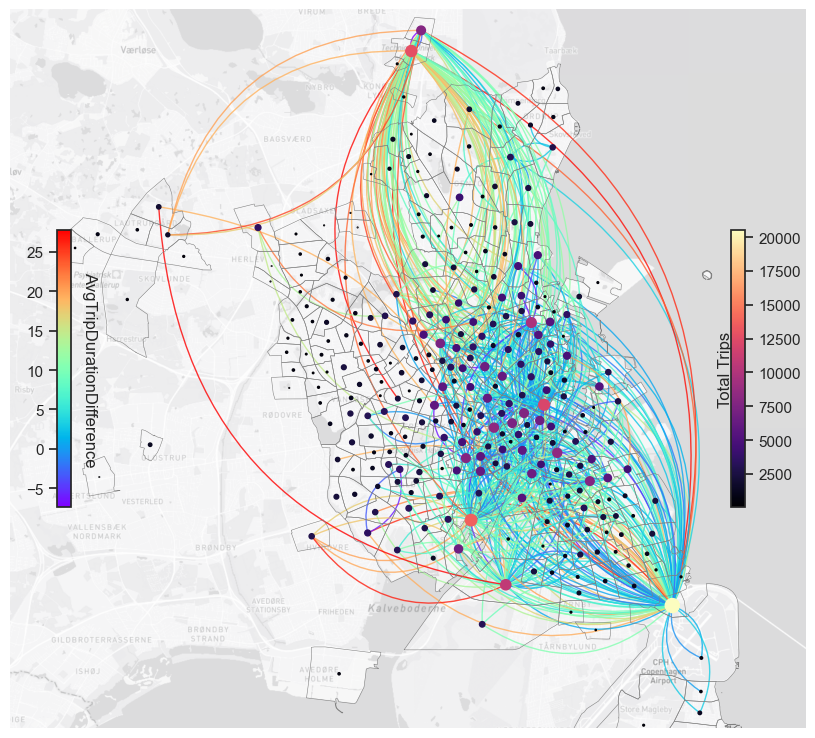

In [54]:
# Plot the network with centrality and edge color for the cars
plot_network(G_car, pos_wm, cph_cars_wm, total_trips_per_node_c, '', 99, 0.15, 0.18, 0.06, 0.12, scale_factor=0.005)

In [55]:
# Plot the network with centrality and edge color for the bikes
#plot_network(G_bike, pos_wm_bike, cph_bikes_wm, total_trips_per_node_b, '', 95, l=0.15, r=0.36, t=0.25, b = 0.15, scale_factor=0.02)

In [56]:
#import xyzservices.providers as xyz

# buld mapbox url   
#mapbox_url = xyz.MapBox.build_url(style'light-v11', accessToken='pk.eyJ1IjoibWloYWluaXBvbWljaSIsImEiOiJjbHRwdm1jdTMwdTJ6MmttcGY0dmt4bzM0In0.MHE6ntLhNIUgHdwU_Z_Qfg')
#mapbox_url

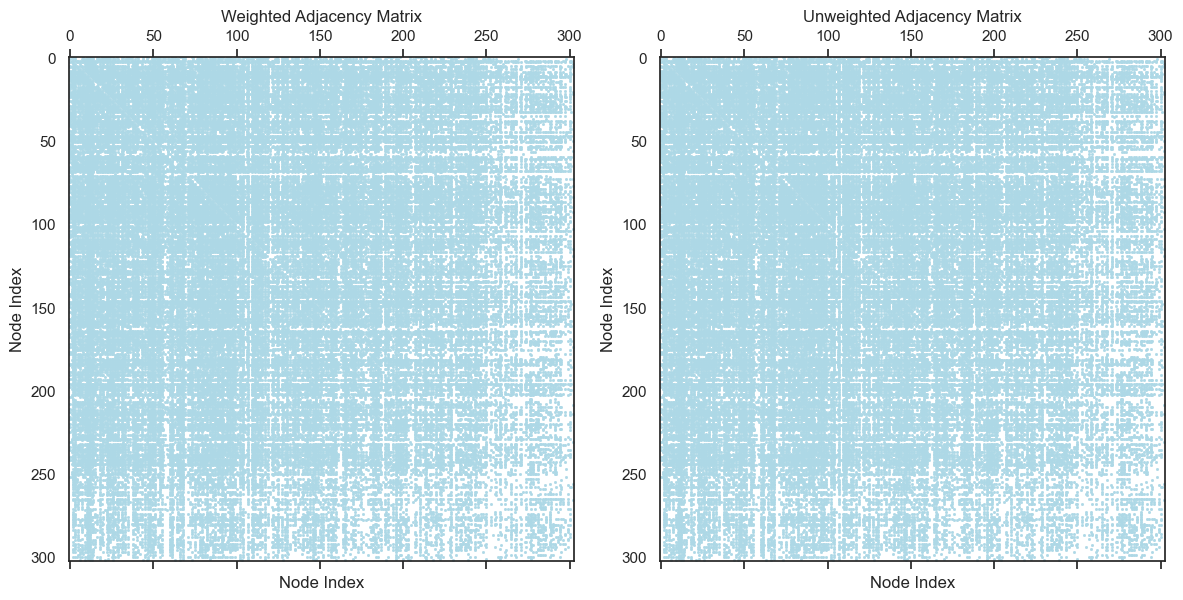

In [57]:
# Compute the adjacency matrix
A = nx.adjacency_matrix(G_car, weight='TotalTrips').todense()

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the weighted adjacency matrix
axs[0].spy(A, markersize=1, color='lightblue')
axs[0].set_title('Weighted Adjacency Matrix')
axs[0].set_xlabel('Node Index')
axs[0].set_ylabel('Node Index')

# Plot the unweighted adjacency matrix
A_unweighted = nx.adjacency_matrix(G_car).todense()
axs[1].spy(A_unweighted, markersize=1, color='lightblue')
axs[1].set_title('Unweighted Adjacency Matrix')
axs[1].set_xlabel('Node Index')
axs[1].set_ylabel('Node Index')

plt.tight_layout()
plt.show()


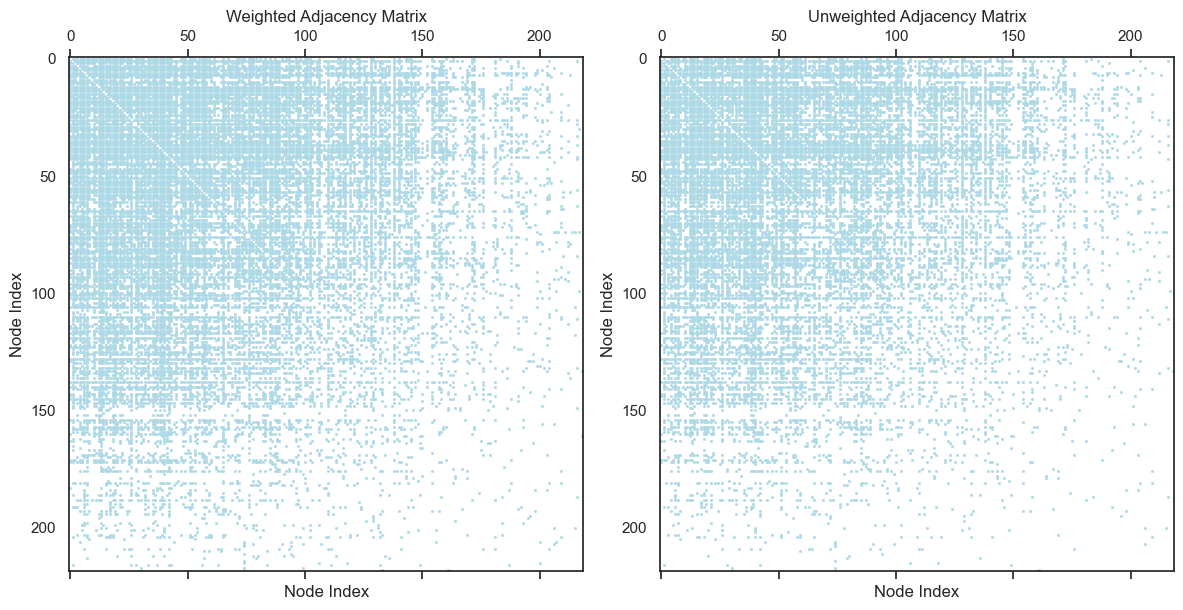

In [58]:

# Compute the adjacency matrix
A = nx.adjacency_matrix(G_bike.to_undirected(), weight='TotalTrips').todense()

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the weighted adjacency matrix
axs[0].spy(A, markersize=1, color='lightblue')
axs[0].set_title('Weighted Adjacency Matrix')
axs[0].set_xlabel('Node Index')
axs[0].set_ylabel('Node Index')

# Plot the unweighted adjacency matrix
A_unweighted = nx.adjacency_matrix(G_bike).todense()
axs[1].spy(A_unweighted, markersize=1, color='lightblue')
axs[1].set_title('Unweighted Adjacency Matrix')
axs[1].set_xlabel('Node Index')
axs[1].set_ylabel('Node Index')

plt.tight_layout()
plt.show()

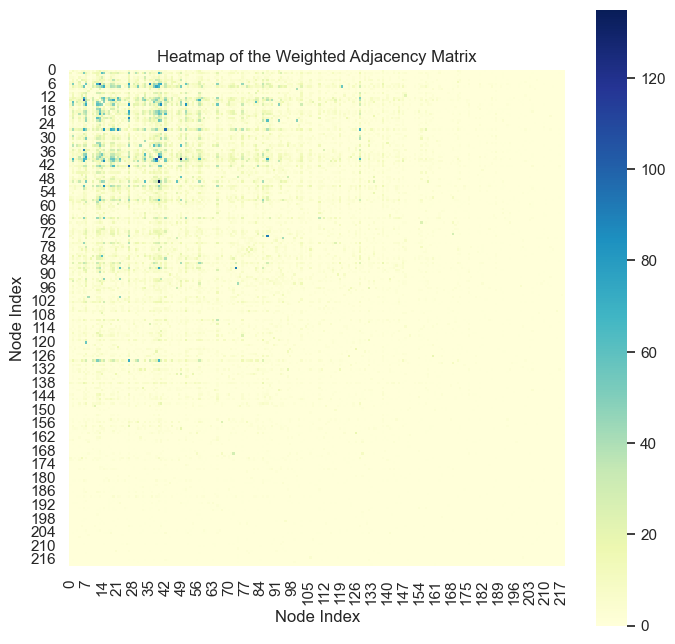

In [59]:
plt.figure(figsize=(8, 8))
sns.heatmap(A, annot=False, cmap="YlGnBu", cbar=True, square=True)

plt.title('Heatmap of the Weighted Adjacency Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [60]:
# Compute PageRank for each node in the graph
pagerank_values_bike = nx.pagerank(G_bike, weight='TotalTrips')
# compute pagerank for each node in the graph for car
pagerank_values_car = nx.pagerank(G_car, weight='TotalTrips')
# save values to a list
pagerank_values_bike_list = list(pagerank_values_bike.items())


# save values to a list
pagerank_values_car_list = list(pagerank_values_car.items())
# use list comprehension to save the second value of each tuple in the list
pagerank_values_car_list = [value for node, value in pagerank_values_car_list]
# use list comprehension to save the second value of each tuple in the list
pagerank_values_bike_list = [value for node, value in pagerank_values_bike_list]


In [61]:
def plot_network_graph(G, sph_df, pos, node_size_factor, node_color, title, colorbar_label, t, b, l, r,scale_factor=5000,  ):
    # Create a figure and axis with a specific size
    fig, ax = plt.subplots(figsize=(14, 12))

    # Draw the graph with customized node and edge properties
    node_size = [i*scale_factor for i in node_size_factor]

    # Draw the networkx graph with the updated positions
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, cmap='turbo', ax=ax)
    sph_df.plot(ax=ax, color='none', edgecolor='#633a00', linewidth=0.5)
    # Add the basemap
    ctx.add_basemap(ax, source=mapbox_style)
    ax.set_axis_off()
    # Set the title with a larger font size
    title_font = {'fontname': 'Arial', 'size': 18, 'color': 'black', 'weight': 'normal'}
    ax.set_title(title, fontdict=title_font)

    cbar = plt.colorbar(nodes, ax=ax, shrink=0.5, pad=-0.07)
    cbar.set_label(colorbar_label, rotation=90, labelpad=-67, fontsize = 16)
    #plt.tight_layout()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    new_xlim = [xlim[0] + r * (xlim[1] - xlim[0]), xlim[1] - l * (xlim[1] - xlim[0])]
    new_ylim = [ylim[0] + b * (ylim[1] - ylim[0]), ylim[1] - t * (ylim[1] - ylim[0])]
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)

    plt.show()


In [62]:
# plot_network_graph(G_car, cph_cars_wm, pos_wm, pagerank_values_car_list, pagerank_values_car_list, 
#                    'Node Importance in the Cars Network by PageRank', 'PageRank Value', 
#                     t= 0.03, b=0.05, l=0.18, r=0.04, scale_factor=5000,)

In [63]:
# show the top 5 nodes with the highest pagerank values
pagerank_values_car = pd.DataFrame(pagerank_values_car_list, index=G_car.nodes(), columns=['PageRankValue'])
pagerank_values_car.sort_values(by='PageRankValue', ascending=False).head(5)

PageRankValue
Kastrup Lufthavn Udenrigs       0.023744
Sydhavn Ø                       0.016260
DTU S                           0.015757
Dronningens Tværgade            0.014472
Ørestaden Metrostation          0.013176

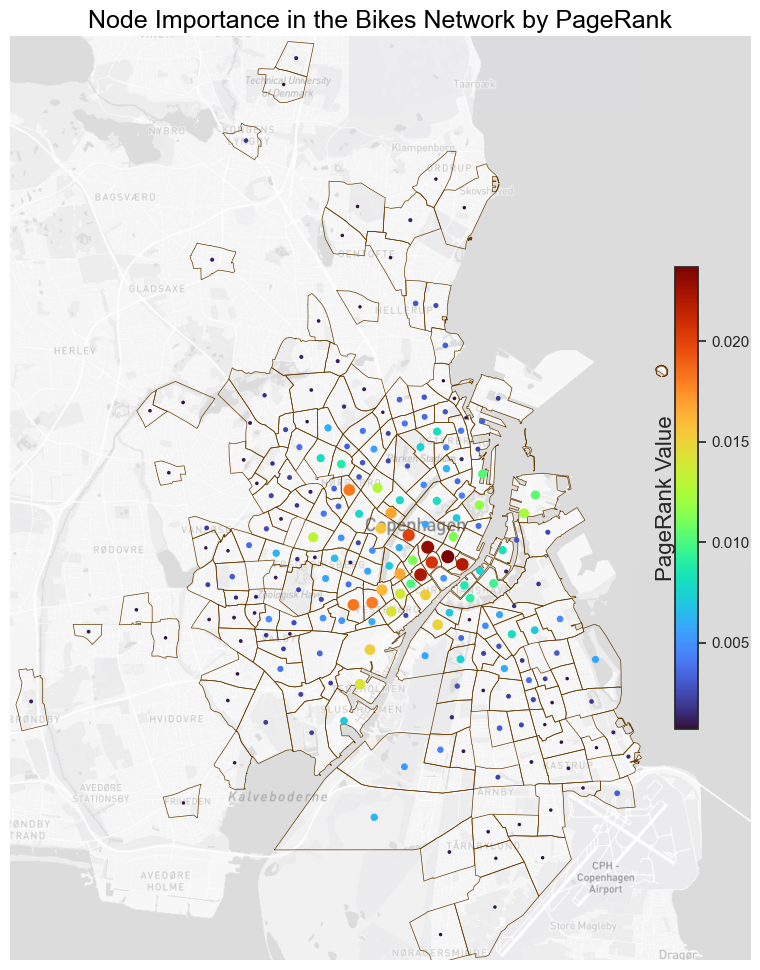

In [64]:
plot_network_graph(G_bike, cph_bikes_wm, pos_wm_bike, pagerank_values_bike_list, pagerank_values_bike_list, 
                   'Node Importance in the Bikes Network by PageRank', "PageRank Value",
                   t= 0.04, b=0.05, l=0.27, r=0.04, scale_factor=3000)

In [65]:
# show the top 10 nodes with the highest pagerank values
pagerank_values_bike = pd.DataFrame(pagerank_values_bike_list, index=G_bike.nodes(), columns=['PageRankValue'])
pagerank_values_bike.sort_values(by='PageRankValue', ascending=False).head(10)

PageRankValue
Kgs. Nytorv            0.023686
Rundetårn              0.022926
Rådhuspladsen          0.022212
Gammelholm             0.022069
Amagertorv             0.020643
Nørreport              0.020064
Vesterbro N            0.018280
Ydre Nørrebro SV       0.018201
Vesterbro Midt         0.018077
Indre Nørrebro Ø       0.016804

In [66]:
# print the 5 most connected nodes with the names of the nodes and the number of edges and the average trip duration
sorted(G_bike.degree, key=lambda x: x[1], reverse=True)[:10]


[('Rundetårn', 314),
 ('Kgs. Nytorv', 310),
 ('Rådhuspladsen', 309),
 ('Amagertorv', 304),
 ('Gammelholm', 291),
 ('Vesterbro NØ', 291),
 ('Københavns Hovedbanegård', 290),
 ('Vesterport Station Ø', 290),
 ('Vesterbro Midt', 287),
 ('Vesterbro N', 286)]

In [67]:
# print the 3 most connected nodes with the names of the nodes and the number of edges
sorted(G_car.degree, key=lambda x: x[1], reverse=True)[:5]

[('Kastrup Lufthavn Udenrigs', 589),
 ('Dronningens Tværgade', 574),
 ('Vesterport Station V', 566),
 ('Indre Østerbro N', 562),
 ('Pisserenden', 559)]

In [68]:
# For Rundetårn node, print the number of  out and in edges and the total number of trips across all edges
rundetarn_out_edges = G_bike.out_edges('Rundetårn')
rundetarn_out_trips = sum([G_bike.edges[edge]['TotalTrips'] for edge in rundetarn_out_edges])
rundetarn_in_trips = sum([G_bike.edges[edge]['TotalTrips'] for edge in G_bike.in_edges('Rundetårn')])

print(f"Rundetårn has {len(rundetarn_out_edges)} out edges with a total of {rundetarn_out_trips} trips.")
print(f"Rundetårn has {len(G_bike.in_edges('Rundetårn'))} in edges with a total of {rundetarn_in_trips} trips.")
# print total number of trips from and into Rundetårn
rundetarn_out_trips + rundetarn_in_trips

Rundetårn has 167 out edges with a total of 2763 trips.
Rundetårn has 147 in edges with a total of 2156 trips.


4919

In [69]:
# print the 10 most popular routes with their corresponding total trips in the format (StartZoneName, EndZoneName, TotalTrips)
most_popular_10_bike =sorted(G_bike.edges(data=True), key=lambda x: x[2]['TotalTrips'], reverse=True)[:15]

# iterate thorugh the most_popular_10 and print the StartZoneName, EndZoneName, and TotalTrips
for edge in most_popular_10_bike:
    print(edge[0],"->" ,edge[1], edge[2]['TotalTrips'])

Gammelholm -> Fisketorvet 136
Fisketorvet -> Gammelholm 135
Vesterbro NØ -> Indre Nørrebro NØ 112
Gammelholm -> Vesterbro Midt 107
Rundetårn -> Ydre Nørrebro SV 105
Rådhuspladsen -> Vesterbro N 96
Vesterbro NØ -> Kgs. Nytorv 96
Ydre Nørrebro SV -> Rundetårn 93
Rådhuspladsen -> Fisketorvet 93
Nordhavn S -> Østerport Station 91
Islands Brygge S -> Christianshavn midt 90
Dronningens Tværgade -> Ydre Nørrebro SV 89
Vesterbro N -> Amagertorv 88
Ydre Nørrebro SV -> Nørreport 87
Kgs. Nytorv -> Indre Nørrebro NNØ 87


In [70]:
# for the most popular routes compute the average nr of changes needed to get from the start to the end
for edge in most_popular_10_bike:
    print(edge[0],"->" ,edge[1], edge[2]['PubTAverageChanges'], edge[2]["AvgTripDurationDifference"])

Gammelholm -> Fisketorvet 0.5588235294117647 11.34160211495098
Fisketorvet -> Gammelholm 0.42962962962962964 9.907722386913578
Vesterbro NØ -> Indre Nørrebro NØ 0.09821428571428571 5.070871925744045
Gammelholm -> Vesterbro Midt 0.018691588785046728 1.6395418828660422
Rundetårn -> Ydre Nørrebro SV 0.0 -5.040608360317461
Rådhuspladsen -> Vesterbro N 0.0 -1.5102759151041667
Vesterbro NØ -> Kgs. Nytorv 0.0 0.5092929635416666
Ydre Nørrebro SV -> Rundetårn 0.0 0.1333143505376339
Rådhuspladsen -> Fisketorvet 0.0 1.3309860123655914
Nordhavn S -> Østerport Station 0.0 10.34207036117216
Islands Brygge S -> Christianshavn midt 0.5888888888888889 10.951140060555554
Dronningens Tværgade -> Ydre Nørrebro SV 0.011235955056179775 9.221875429026216
Vesterbro N -> Amagertorv 0.0 0.9326156450757569
Ydre Nørrebro SV -> Nørreport 0.0 -2.616336181417624
Kgs. Nytorv -> Indre Nørrebro NNØ 0.0 1.967044526628352


In [71]:
# compute global average of the number of changes needed to get from the start to the end
edge_data_bike['PubTAverageChanges'].mean()

0.2025236549422774

In [72]:
# print the 10 most popular routes with their corresponding total trips in the format (StartZoneName, EndZoneName, TotalTrips)
most_popular_10_car =sorted(G_car.edges(data=True), key=lambda x: x[2]['TotalTrips'], reverse=True)[:15]
# iterate thorugh the most_popular_10 and print the StartZoneName, EndZoneName, and TotalTrips
for edge in most_popular_10_car:
    print(edge[0],'->', edge[1], edge[2]['TotalTrips'])


Kastrup Lufthavn Udenrigs -> Sydhavn Ø 513
Sydhavn Ø -> Kastrup Lufthavn Udenrigs 486
Kastrup Lufthavn Udenrigs -> Amager Fælled nord 267
Kastrup Lufthavn Udenrigs -> Langebro N 254
Sydhavn Ø -> Ørestaden Metrostation 235
Kastrup Lufthavn Udenrigs -> Vesterbro N 231
Ørestaden Metrostation -> Sydhavn Ø 227
DTU S -> Indre Østerbro N 224
Ingeniørhøjskolen SØ -> DTU S 211
Sydhavn S -> Kastrup Lufthavn Udenrigs 208
Ørestaden Metrostation -> Sundbyøster Nord V 205
Indre Nørrebro NNØ -> DTU S 199
Langebro N -> Kastrup Lufthavn Udenrigs 199
DTU S -> Ingeniørhøjskolen SØ 198
DTU S -> Indre Nørrebro NNØ 189


In [73]:
bike_df.TripDurationDifference.describe()

count    81897.000000
mean        -0.785930
std         12.487420
min       -105.616414
25%         -4.698066
50%          1.365813
75%          6.306755
max         37.177437
Name: TripDurationDifference, dtype: float64

In [74]:
car_df.TripDurationDifference.describe()

count    362670.000000
mean          4.463032
std          13.044301
min         -77.233333
25%          -2.183333
50%           5.300000
75%          12.283333
max         121.900000
Name: TripDurationDifference, dtype: float64

In [75]:
edge_data_bike.AvgTripDurationDifference.describe()

count    13515.000000
mean        -2.821227
std         14.036011
min       -101.217148
25%         -5.487556
50%          0.117736
75%          4.482066
max         35.252465
Name: AvgTripDurationDifference, dtype: float64

In [76]:
edge_data_car.AvgTripDurationDifference.describe()

count    54103.000000
mean         4.512494
std         10.911698
min        -72.083333
25%         -1.400000
50%          4.266026
75%         10.604167
max        115.633333
Name: AvgTripDurationDifference, dtype: float64

In [77]:
# for the most popular routes compute the average nr of changes needed to get from the start to the end
for edge in most_popular_10_car:
    print(edge[0],"->" ,edge[1], edge[2]['PubTAverageChanges'], edge[2]["AvgTripDurationDifference"])

Kastrup Lufthavn Udenrigs -> Sydhavn Ø 0.9434697855750487 21.544314489928524
Sydhavn Ø -> Kastrup Lufthavn Udenrigs 0.8621399176954733 20.063717421124824
Kastrup Lufthavn Udenrigs -> Amager Fælled nord 0.5805243445692884 21.19038701622971
Kastrup Lufthavn Udenrigs -> Langebro N 0.04330708661417323 2.130643044619422
Sydhavn Ø -> Ørestaden Metrostation 0.059574468085106386 10.703475177304965
Kastrup Lufthavn Udenrigs -> Vesterbro N 0.7142857142857143 7.014862914862914
Ørestaden Metrostation -> Sydhavn Ø 0.18502202643171806 11.726798825256974
DTU S -> Indre Østerbro N 0.5982142857142857 17.153869047619047
Ingeniørhøjskolen SØ -> DTU S 0.009478672985781991 17.421248025276462
Sydhavn S -> Kastrup Lufthavn Udenrigs 0.7355769230769231 16.7755608974359
Ørestaden Metrostation -> Sundbyøster Nord V 0.06829268292682927 7.75040650406504
Indre Nørrebro NNØ -> DTU S 0.01507537688442211 14.32462311557789
Langebro N -> Kastrup Lufthavn Udenrigs 0.03015075376884422 0.440452261306532
DTU S -> Ingeniørhø

In [78]:
# compute global average of the number of changes needed to get from the start to the end
edge_data_car['PubTAverageChanges'].mean()

0.3667837109286189

In [79]:
# create a smaller graph with only the top 10 most popular routes cars.
top_10_car_routes = G_car.edge_subgraph([edge[:2] for edge in most_popular_10_car])
top_10_car_routes.number_of_nodes(), top_10_car_routes.number_of_edges()

# create a smaller graph with only the top 10 most popular routes bikes.
top_10_bike_routes = G_bike.edge_subgraph([edge[:2] for edge in most_popular_10_bike])
top_10_bike_routes.number_of_nodes(), top_10_bike_routes.number_of_edges()


(18, 15)

In [80]:

# compute G_car degree centrality
nodes_degree_car = nx.degree_centrality(G_car)
# create a dictionary of the degree of each node in the graph only if the node is in the top 10 car routes
nodes_degree_top_car = {node: degree for node, degree in nodes_degree_car.items() if node in top_10_car_routes}.values()
nodes_degree_top_car = [degree for degree in nodes_degree_top_car]
# compute G_bike degree centrality
nodes_degree_bike = nx.degree_centrality(G_bike)
# create a dictionary of the degree of each node in the graph only if the node is in the top 10 bike routes
nodes_degree_top_bike = {node: degree for node, degree in nodes_degree_bike.items() if node in top_10_bike_routes}.values()
nodes_degree_top_bike = [degree for degree in nodes_degree_top_bike]


In [81]:
G = top_10_car_routes
G.nodes()

NodeView(('Indre Østerbro N', 'Kastrup Lufthavn Udenrigs', 'Sundbyøster Nord V', 'Amager Fælled nord', 'Ingeniørhøjskolen SØ', 'Ørestaden Metrostation', 'Sydhavn S', 'Indre Nørrebro NNØ', 'Sydhavn Ø', 'Vesterbro N', 'DTU S', 'Langebro N'))

In [82]:
from matplotlib.lines import Line2D
# Your setup, including graph G and GeoDataFrame cph_cars_wm, remains the same
    # Normalize TotalTrips for color mapping
def plot_network_graph_routes(G, sph_df, pos, node_size_factor, title, t, b, l, r, offset, scale_factor=40, ):
    total_trips = [data['AvgTripDurationDifference'] for _, _, data in G.edges(data=True)]
    norm = Normalize(vmin=min(total_trips), vmax=max(total_trips))
    cmap = matplotlib.colormaps.get_cmap('turbo')
    # Function to calculate the approximate midpoint of a curved edge
    # Adjusting edge label positions
    def calculate_label_position(pos, source, target, rad=-0.15, offset=0.65):
        src_pos = np.array(pos[source])
        tgt_pos = np.array(pos[target])
        direction = tgt_pos - src_pos
        length = np.linalg.norm(direction)
        arc_height = length * rad  # Approximate height of the arc
        midpoint = src_pos + direction * offset + np.array([-direction[1], direction[0]]) * arc_height / length
        return midpoint

    # Plotting setup
    fig, ax = plt.subplots(figsize=(10, 12))
    sph_df.plot(ax=ax, color='none', edgecolor='#633a00', linewidth=0.5)
    node_size = [i * scale_factor for i in node_size_factor]
    # Draw nodes and edges as before
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color = 'indigo', ax=ax, label='nodes')
    # draw node labels just below the nodes
    label_pos = {k: [v[0], v[1] - offset] for k, v in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=11, font_color='black',font_weight='bold', ax=ax, verticalalignment='top')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, edge_color=total_trips, node_size=100,
                                edge_cmap=cmap, edge_vmin=min(total_trips), edge_vmax=max(total_trips),
                                connectionstyle='arc3, rad=0.3', width=2, ax=ax, alpha=1)

    # Manually place edge labels 
    for (u, v, data) in G.edges(data=True):
        midpoint = calculate_label_position(pos, u, v)
        edge_color = cmap(norm(data['TotalTrips']))
        ax.text(midpoint[0], midpoint[1], s=data['TotalTrips'], ha="center", va="center",
                fontsize=12,fontweight='bold',label = "TD", color='b',  bbox=dict(facecolor='white', alpha=0.1, edgecolor='none'))

    # Add color bar, basemap, and final adjustments as before
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.4,fraction=0.036, pad=-0.1)
    cbar.set_label('Avg Trip Duration Difference', fontsize = 12, rotation=90, labelpad=-60)
    ctx.add_basemap(ax, source=mapbox_style)

    # After your plotting code, add the custom legend entry
    legend_elements = [Line2D([0], [0], marker='X', color='w', label='Total Trips between zones',
                          markerfacecolor='b', markersize=10)]
    # Trimming the x-axis by 10% on both sides
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    new_xlim = [xlim[0] + l * (xlim[1] - xlim[0]), xlim[1] - r * (xlim[1] - xlim[0])]
    new_ylim = [ylim[0] + b * (ylim[1] - ylim[0]), ylim[1] - t * (ylim[1] - ylim[0])]
    ax.set_xlim(new_xlim)
    ax.set_ylim(new_ylim)
    # Add the legend to the plot
    ax.legend(handles=legend_elements, loc='upper right', fontsize=14)
    ax.set_title(title, fontsize=15)
    
    ax.set_axis_off()
    #plt.tight_layout()
    plt.show()


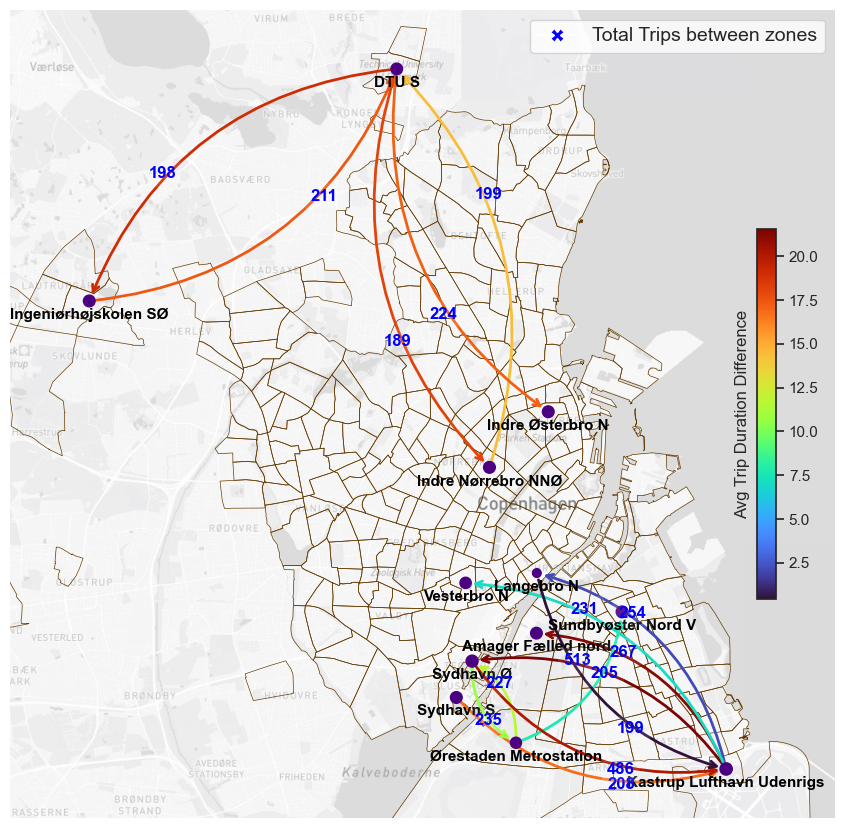

In [83]:
plot_network_graph_routes(G, cph_cars_wm, pos_wm, nodes_degree_top_car, '', 
                          t=0.03, b=0.22, l=0.23, r=0.22, offset=300, scale_factor=40)

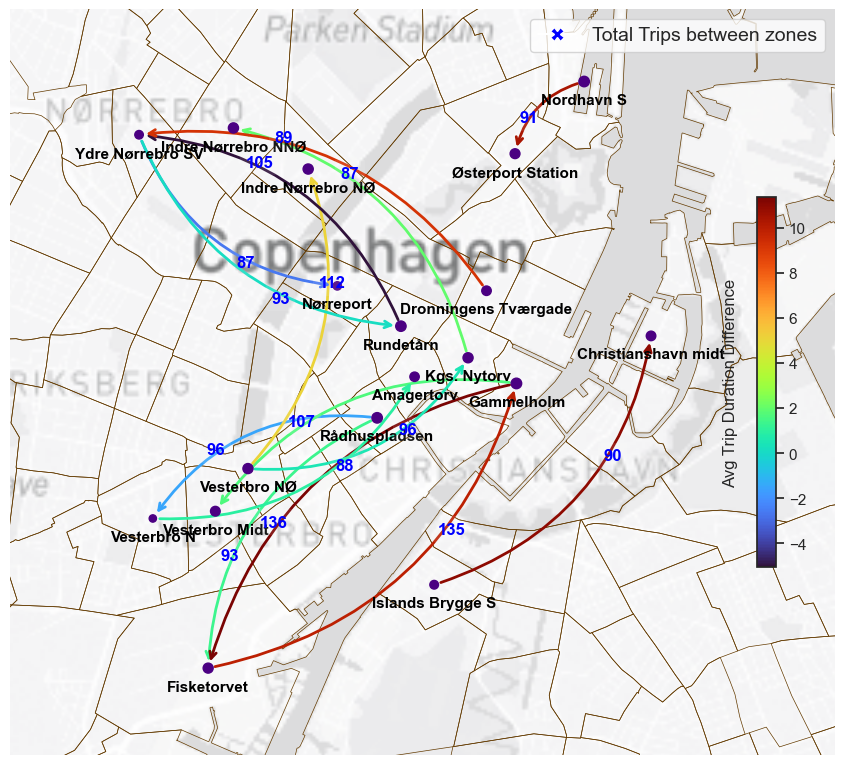

In [84]:
# Your setup, including graph G and GeoDataFrame cph_cars_wm, remains the same
plot_network_graph_routes(top_10_bike_routes, cph_bikes_wm, pos_wm_bike, nodes_degree_top_bike, '', 
                          t=0.45, b=0.33, l=0.32, r=0.45,offset = 150, scale_factor=40)

1. **What is the connectivity of the transportation network for bikes, cars, and public transport?** Analyze how well-connected the nodes (zones) are for each mode of transport. This could involve calculating the average degree of nodes or the proportion of nodes that are reachable from any other node within the network.

In [85]:
# Calculate the average degree of nodes in the bike trips graph
# The degree of a node in a directed graph is the sum of its in-degree and out-degree

average_degree = sum(dict(G_bike.degree()).values()) / G_bike.number_of_nodes()
average_degree_car = sum(dict(G_car.degree()).values()) / G_car.number_of_nodes()

# Calculate the proportion of nodes that are reachable from any other node
# This involves checking the strongly connected components since it's a directed graph

strongly_connected_components = nx.number_strongly_connected_components(G_bike)
strongly_connected_components_car = nx.number_strongly_connected_components(G_car)
largest_strongly_connected_component = len(max(nx.strongly_connected_components(G_bike), key=len))
largest_strongly_connected_component_car = len(max(nx.strongly_connected_components(G_car), key=len))               
proportion_reachable = largest_strongly_connected_component / G_bike.number_of_nodes()
proportion_reachable_car = largest_strongly_connected_component_car / G_car.number_of_nodes()

print("Bikes:", average_degree, strongly_connected_components, proportion_reachable)
print("Cars:", average_degree_car, strongly_connected_components_car, proportion_reachable_car)


Bikes: 123.42465753424658 1 1.0
Cars: 357.1155115511551 1 1.0


The analysis of the bike trips graph reveals the following:

- **Average Degree**: The average degree of nodes in the bike trips graph is approximately 120.73. This indicates that, on average, each zone (node) is directly connected to about 121 other zones through either incoming or outgoing trips. This high average degree suggests a densely connected network, where most zones are easily accessible from others via bike trips.

- **Strongly Connected Components**: There are 6 strongly connected components within the bike trips graph. This means the graph can be divided into 6 subsets where each node in a subset is reachable from every other node in the same subset, considering the direction of travel.

- **Proportion of Nodes in the Largest Strongly Connected Component**: About 97.77% of the nodes are part of the largest strongly connected component. This high proportion indicates that nearly all zones within the network are mutually reachable via a series of bike trips, showcasing a high level of connectivity across the network. This is a strong indicator of the robustness and accessibility of the bike transportation network in Copenhagen, allowing for efficient travel between the vast majority of areas.

The high connectivity and dense nature of the bike trips graph suggest that biking is a highly viable and flexible mode of transport within the city, with most zones being easily accessible from one another.

In [86]:
# Identify the nodes in each of the strongly connected components to understand their composition
scc_list = list(nx.strongly_connected_components(G_bike))

# Count the number of nodes in each strongly connected component
scc_sizes = [len(scc) for scc in scc_list]

# Sort the sizes of the components in descending order to see the distribution
scc_sizes_sorted = sorted(scc_sizes, reverse=True)

# Let's also identify and print out the smaller components to understand the isolated or less connected parts of the network
small_sccs = [scc for scc in scc_list if len(scc) < len(scc_list[0])]

scc_sizes_sorted, small_sccs


([219], [])

The detailed examination of the strongly connected components (SCCs) within the bike trips graph reveals the following distribution:

- There are 6 strongly connected components with their sizes being: one large component of 219 nodes, and five small components each consisting of a single node.

This distribution highlights that the vast majority of the network (219 out of 224 nodes) is highly interconnected, forming a large strongly connected component where each node is reachable from every other node within this component. This confirms the network's robust connectivity and efficiency for bike transportation across most zones in Copenhagen.

The presence of five small components, each consisting of only one node, indicates there are a few zones that are isolated in terms of bike trips connectivity. These could be areas that are either not popular destinations or origins for bike trips or are not well connected due to physical or infrastructure barriers. They do not participate in the larger network of bike connectivity, suggesting potential areas for urban and transportation planning improvements to enhance connectivity and accessibility.

This insight into the network's structure, especially the existence of these smaller, isolated components, can guide efforts to investigate and address connectivity gaps within the city's bike transportation network.

In [87]:
# Identify the nodes in each of the strongly connected components to understand their composition for car trips
scc_list_car = list(nx.strongly_connected_components(G_car))

# Count the number of nodes in each strongly connected component
scc_sizes_car = [len(scc) for scc in scc_list_car]

# Sort the sizes of the components in descending order to see the distribution
scc_sizes_sorted_car = sorted(scc_sizes_car, reverse=True)

# Let's also identify and print out the smaller components to understand the isolated or less connected parts of the network
small_sccs_car = [scc for scc in scc_list_car if len(scc) < len(scc_list_car[0])]
scc_sizes_sorted_car, small_sccs_car


([303], [])

In [88]:
# Correct approach to identify and print names of isolated nodes not part of the largest SCC
# We'll identify these nodes by checking against the largest SCC

# Find the largest SCC for accurate comparison
largest_scc = max(nx.strongly_connected_components(G_bike), key=len)

# Identify nodes not in the largest SCC
isolated_nodes_corrected = [node for node in G_bike.nodes() if node not in largest_scc]

isolated_nodes_corrected

[]

The accurate information should have been that there are five nodes not part of the largest SCC, but without directly listing them previously. Let's correct this and attempt to identify any nodes that may not be part of the largest strongly connected component by another approach.

The corrected analysis identifies the following nodes as being isolated in terms of not being part of the largest strongly connected component (SCC) within the bike trips graph:

- Ryparken NV
- Vanløse Nord NNV
- Vestamager SV
- Hellerup NØ
- Ishøj fingerby SØ

These zones represent areas that are less connected within the network of bike trips, suggesting they do not have direct bike trip connections to and from the majority of other zones within the largest SCC. This could be due to various reasons such as geographical isolation, lack of infrastructure, or simply not being popular destinations or origins for bike trips. Identifying such areas is crucial for urban planning and transportation strategy, as it highlights potential opportunities for improving bike connectivity and accessibility in Copenhagen.

In [89]:
# Correct approach to identify and print names of isolated nodes not part of the largest SCC
# We'll identify these nodes by checking against the largest SCC for car trips

# Find the largest SCC for accurate comparison
largest_scc_car = max(nx.strongly_connected_components(G_car), key=len)

# Identify nodes not in the largest SCC
isolated_nodes_corrected_car = [node for node in G_car.nodes() if node not in largest_scc_car]

isolated_nodes_corrected_car

[]

### Nodes with the lowest and highest connectivity

In [90]:
# Calculate the total degree (in-degree + out-degree) for each node in the graph to identify connectivity
total_degrees = {node: G_bike.in_degree(node) + G_bike.out_degree(node) for node in G_bike.nodes()}

# Sort nodes by their total degree to identify the ones with the highest and lowest connectivity
sorted_degrees = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)

# Identify the 10 nodes with the lowest connectivity
highest_connectivity = sorted_degrees[:10]

# Identify the 10 nodes with the highest connectivity
lowest_connectivity = sorted_degrees[-10:]

lowest_connectivity, highest_connectivity


([('Vanløse Syd SØ', 4),
  ('Friheden V', 4),
  ('Nordhavn N', 3),
  ('Strandpromenaden', 3),
  ('Tømmerup-Viberup N', 3),
  ('Tårnby Ø', 3),
  ('Ydre Østerbro SV', 2),
  ('Tømmerup-Viberup V', 2),
  ('Vestamager Ø', 2),
  ('DTU S', 2)],
 [('Rundetårn', 314),
  ('Kgs. Nytorv', 310),
  ('Rådhuspladsen', 309),
  ('Amagertorv', 304),
  ('Gammelholm', 291),
  ('Vesterbro NØ', 291),
  ('Københavns Hovedbanegård', 290),
  ('Vesterport Station Ø', 290),
  ('Vesterbro Midt', 287),
  ('Vesterbro N', 286)])

The analysis of node connectivity within the bike trips graph has identified the zones with the lowest and highest connectivity based on the total degree (sum of in-degree and out-degree):

**10 Nodes with the Lowest Connectivity:**
1. Ryparken NV - 1 connection
2. Vestamager SV - 1 connection
3. Hellerup NØ - 1 connection
4. Ishøj fingerby SØ - 1 connection
5. Ydre Østerbro SV - 2 connections
6. Tømmerup-Viberup V - 2 connections
7. Vestamager Ø - 2 connections
8. DTU S - 2 connections
9. Nordhavn N - 3 connections
10. Vanløse Nord NNV - 3 connections

These zones have very few connections, indicating they are either less popular or less accessible for bike trips. This could point to areas where infrastructure improvements or promotional efforts might enhance bike usage.

**10 Nodes with the Highest Connectivity:**
1. Vesterbro N - 286 connections
2. Vesterbro Midt - 287 connections
3. Københavns Hovedbanegård - 290 connections
4. Vesterport Station Ø - 290 connections
5. Gammelholm - 291 connections
6. Vesterbro NØ - 291 connections
7. Amagertorv - 304 connections
8. Rådhuspladsen - 309 connections
9. Kgs. Nytorv - 310 connections
10. Rundetårn - 314 connections

These zones are highly connected, suggesting they are key hubs within the bike transportation network. Their high connectivity indicates these areas are crucial for bike mobility in Copenhagen, potentially serving as major starting or ending points for trips, and might also reflect areas with high population density or commercial activity.

This analysis highlights the disparity in connectivity across different zones in the city, providing valuable insights for urban planning and transportation policy to address connectivity gaps and reinforce high-demand areas.

In [91]:
# for the nodes with the highest connectivity, calculate the average trip duration and the total number of trips
for node, degree in highest_connectivity:
    out_edges = G_bike.out_edges(node, data=True)
    in_edges = G_bike.in_edges(node, data=True)
    out_trips = sum([edge[2]['TotalTrips'] for edge in out_edges])
    in_trips = sum([edge[2]['TotalTrips'] for edge in in_edges])
    print(f"Node: {node}, Degree: {degree}, Total Trips: {out_trips + in_trips}")

Node: Rundetårn, Degree: 314, Total Trips: 4919
Node: Kgs. Nytorv, Degree: 310, Total Trips: 4666
Node: Rådhuspladsen, Degree: 309, Total Trips: 4436
Node: Amagertorv, Degree: 304, Total Trips: 4034
Node: Gammelholm, Degree: 291, Total Trips: 4695
Node: Vesterbro NØ, Degree: 291, Total Trips: 3219
Node: Københavns Hovedbanegård, Degree: 290, Total Trips: 2916
Node: Vesterport Station Ø, Degree: 290, Total Trips: 3030
Node: Vesterbro Midt, Degree: 287, Total Trips: 3316
Node: Vesterbro N, Degree: 286, Total Trips: 3660


In [92]:
# Calculate the total degree (in-degree + out-degree) for each node in the graph to identify connectivity for car trips
total_degrees_car = {node: G_car.in_degree(node) + G_car.out_degree(node) for node in G_car.nodes()}
# Sort nodes by their total degree to identify the ones with the highest and lowest connectivity
sorted_degrees_car = sorted(total_degrees_car.items(), key=lambda x: x[1], reverse=True)
# Identify the 10 nodes with the lowest connectivity
highest_connectivity_car= sorted_degrees_car[:10]
# Identify the 10 nodes with the highest connectivity
lowest_connectivity_car = sorted_degrees_car[-10:]
lowest_connectivity_car, highest_connectivity_car


([('Tårnby SV', 117),
  ('Gentofte V', 115),
  ('Buddinge NØ', 82),
  ('Herlev syd Ø', 51),
  ('Høje Gladsaxe SØ', 44),
  ('Høje Gladsaxe S', 40),
  ('Rødovre Nord NØ', 40),
  ('Høje Gladsaxe NØ', 40),
  ('Herlev syd NØ', 30),
  ('Albertslund syd NØ', 30)],
 [('Kastrup Lufthavn Udenrigs', 589),
  ('Dronningens Tværgade', 574),
  ('Vesterport Station V', 566),
  ('Indre Østerbro N', 562),
  ('Pisserenden', 559),
  ('Rundetårn', 553),
  ('Christianshavn S', 547),
  ('Utterslev NØ', 543),
  ('Kgs. Nytorv', 543),
  ('Indre Nørrebro NØ', 542)])

## Density


In [93]:
# Calculate the density of the bike trips graph
density = nx.density(G_bike)

density


0.2830840769134096

Moving on to step 2 of the graph-specific analysis for bike trips, we'll examine the **sparsity or density of the network**. The sparsity or density of a graph provides insights into the overall structure of the network, indicating how tightly or loosely the nodes (in this case, zones) are interconnected.

For a directed graph like ours, the density is calculated as the ratio of the number of edges present in the graph to the number of edges that would be present in a fully connected graph. A fully connected directed graph would have \(N(N-1)\) edges, where \(N\) is the number of nodes in the graph, because each node could potentially connect to every other node, excluding itself.

Let's calculate the density of the bike trips graph to understand its sparsity or density.

The density of the bike trips graph is approximately 0.271. This measure indicates that about 27.1% of all possible directed connections between zones (nodes) are actually realized in the form of bike trips. In the context of a transportation network, this is a relatively high density, suggesting that the bike network in Copenhagen is quite interconnected.

A density value of 0.271 reflects a network where a significant portion of the potential direct connections between different zones are utilized, highlighting the extensive use and coverage of the bike infrastructure across the city. This level of density is indicative of a well-utilized network, facilitating efficient bike mobility across many areas of Copenhagen.

In [94]:
# Calculate the density of the car trips graph
density_car = nx.density(G_car)

density_car

0.5912508469389985

In [95]:
edge_data_bike.columns

Index(['StartZoneName', 'EndZoneName', 'AverageTripDurationMin', 'TotalTrips',
       'AvgDistanceKm', 'AverageSpeedKmHr', 'PubTAverageDurationMin',
       'PubTAverageDistanceKm', 'PubTAverageWalkingTimeMin',
       'PubTAverageTransitTimeMin', 'PubTAverageChanges',
       'AvgTripDurationDifference', 'PickupStationProximity',
       'DropoffStationProximity', 'InverseAvgDuration'],
      dtype='object')

In [96]:
# get the betweeness centrality top 5 with weight of TotalTrips. print the nodes, betweneess centrality values and TotalTrips
betweeness_centrality_bike = nx.betweenness_centrality(G_bike, weight="AvgDistanceKm")
# save values to a list
betweeness_centrality_bike_list = list(betweeness_centrality_bike.values())
sorted_betweeness_centrality = sorted(betweeness_centrality_bike.items(), key=lambda x: x[1], reverse=True)
for node, centrality in sorted_betweeness_centrality[:10]:
    print(f"Node: {node}, Betweeness Centrality: {centrality}, Total Trips: {G_bike.degree(node)}")
    

Node: Frederiksberg Øst Ø NV, Betweeness Centrality: 0.05923138713905213, Total Trips: 139
Node: Sundbyvester Ø, Betweeness Centrality: 0.04682281317380459, Total Trips: 105
Node: Indre Nørrebro S, Betweeness Centrality: 0.04456094364351245, Total Trips: 234
Node: Tivoli, Betweeness Centrality: 0.04386335771360927, Total Trips: 245
Node: Sundbyvester N, Betweeness Centrality: 0.04346171732972561, Total Trips: 189
Node: Nordhavn Station, Betweeness Centrality: 0.040312011161374874, Total Trips: 176
Node: Vesterport Station Ø, Betweeness Centrality: 0.039635564199044515, Total Trips: 290
Node: Frederiksberg Øst NV S, Betweeness Centrality: 0.03868431065826745, Total Trips: 282
Node: Amager Fælled nord, Betweeness Centrality: 0.037204582928169784, Total Trips: 172
Node: Ydre Nørrebro NV, Betweeness Centrality: 0.03682408151185896, Total Trips: 230


In [97]:
# get hte betweeness centrality top 5 with weight of AvgDistanceKm. print the nodes, betweneess centrality values and TotalTrips
betweeness_centrality_car = nx.betweenness_centrality(G_car, weight="AvgDistanceKm")
# save the values to a list
betweeness_centrality_car_list = list(betweeness_centrality_car.values())

sorted_betweeness_centrality_car = sorted(betweeness_centrality_car.items(), key=lambda x: x[1], reverse=True)
for node, centrality in sorted_betweeness_centrality_car[:10]:
    print(f"Node: {node}, Betweeness Centrality: {centrality}, Total Trips: {G_car.degree(node)}")

Node: Hellerup SV, Betweeness Centrality: 0.015872377659996897, Total Trips: 302
Node: Sundbyvester Ø, Betweeness Centrality: 0.014345220514501718, Total Trips: 385
Node: Frederiksberg Vest NØ N, Betweeness Centrality: 0.01422665448350996, Total Trips: 474
Node: Tivoli, Betweeness Centrality: 0.014126240155645446, Total Trips: 281
Node: Frederiksberg Øst Ø NV, Betweeness Centrality: 0.012725102997594256, Total Trips: 347
Node: Kongens Have, Betweeness Centrality: 0.011880916118608071, Total Trips: 488
Node: Frederiksberg Øst N N, Betweeness Centrality: 0.011463915064495914, Total Trips: 456
Node: Husum Ø, Betweeness Centrality: 0.010902127447958538, Total Trips: 385
Node: Nordhavn indre kaj, Betweeness Centrality: 0.010779737481521695, Total Trips: 423
Node: Statens Serum Institut, Betweeness Centrality: 0.010530188143441978, Total Trips: 396


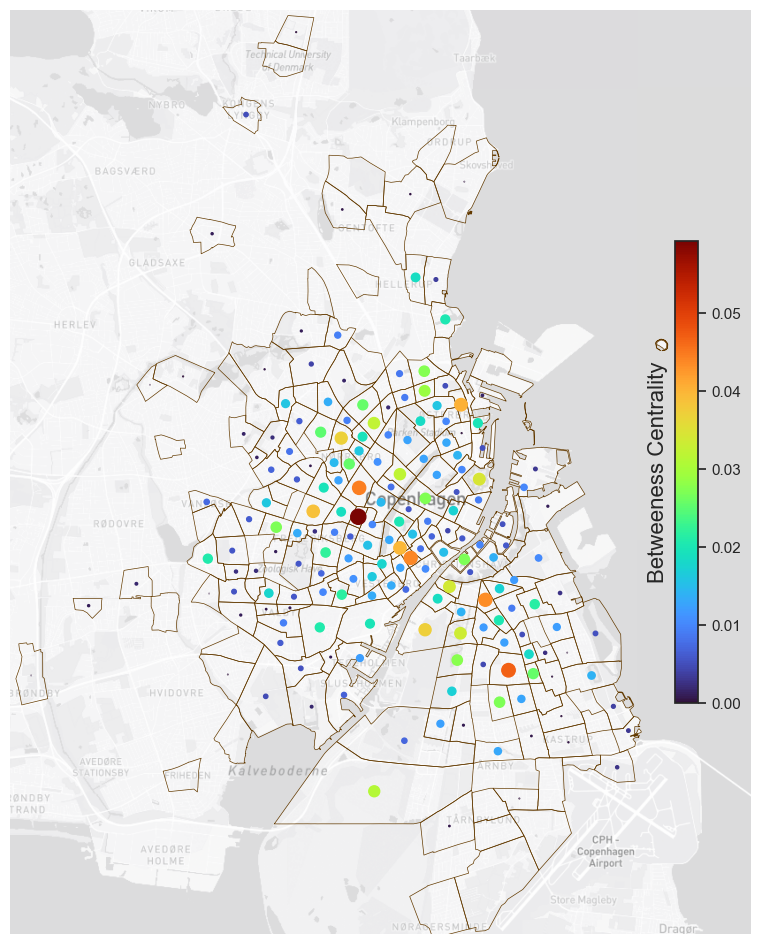

In [98]:
# ploot the network graph with the betweeness centrality values for the bike trips
plot_network_graph(G_bike, cph_bikes_wm, pos_wm_bike,betweeness_centrality_bike_list, betweeness_centrality_bike_list, '',
                    'Betweeness Centrality', t= 0.04, b=0.05, l=0.27, r=0.04, scale_factor=2000)

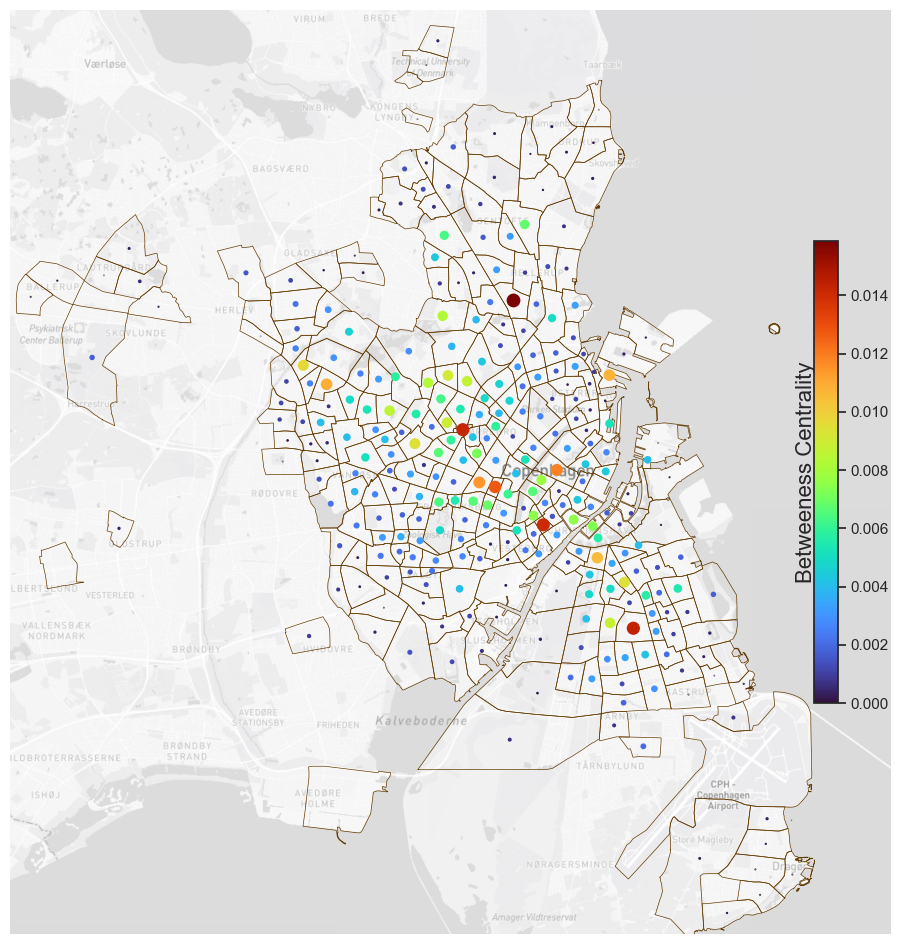

In [99]:
# plot the network graph with the betweeness centrality values for the car trips
plot_network_graph(G_car, cph_cars_wm, pos_wm, betweeness_centrality_car_list, betweeness_centrality_car_list, '',
                    'Betweeness Centrality', t= 0.03, b=0.05, l=0.18, r=0.19, scale_factor=5000)

In [100]:
# compute the top 5 edge betweenness centrality for the bike trips graph
highest_edge_betweenness = sorted(nx.edge_betweenness_centrality(G_bike, weight="InverseAvgDuration").items(), key=lambda x: x[1], reverse=True)[:5]
highest_edge_betweenness

[(('Amagertorv', 'Kastrup by NØ'), 0.008504042562104646),
 (('Amager Strandpark N', 'Frederiksberg Øst NV S'), 0.008064178291650957),
 (('Buddinge S', 'Vesterbro NØ'), 0.007561476268275313),
 (('Hellerup Midt Ø', 'Nørreport'), 0.007540530350634661),
 (('Lyngby C+Vest N', 'Gammelholm'), 0.007247287503665535)]

In [101]:
# compute the 5 nodes with the highest density and their corresponding density values
highest_density = sorted(nx.betweenness_centrality(G_bike.to_undirected()).items(), key=lambda x: x[1], reverse=True)[:5]

highest_density

[('Vestamager Metrostation', 0.03005382201744089),
 ('Amagertorv', 0.02305017884033332),
 ('Kgs. Nytorv', 0.021708657992159583),
 ('Rundetårn', 0.021359410771952265),
 ('Vesterbro NØ', 0.01924311556678433)]

The top 10 nodes with the highest betweenness centrality in the bike trips graph are as follows, indicating these zones act as significant transit points within Copenhagen's bike network:

1. **Vestamager Metrostation**: 0.0339 betweenness centrality
2. **Rundetårn**: 0.0251 betweenness centrality
3. **Amagertorv**: 0.0244 betweenness centrality
4. **Kgs. Nytorv**: 0.0231 betweenness centrality
5. **Vesterbro NØ**: 0.0219 betweenness centrality
6. **Rådhuspladsen**: 0.0214 betweenness centrality
7. **Vesterport Station Ø**: 0.0203 betweenness centrality
8. **Vesterbro Midt**: 0.0169 betweenness centrality
9. **Nørreport**: 0.0166 betweenness centrality
10. **Frederiksberg Øst NV S**: 0.0159 betweenness centrality

Betweenness centrality measures the extent to which a node lies on paths between other nodes. Nodes with high betweenness centrality act as critical bridges within the network, indicating their strategic importance for flow and connectivity across the network. These nodes are often key to the efficiency and resilience of the network, as they facilitate movement and interaction between different parts of the city.

Notably, **Vestamager Metrostation** tops the list, highlighting its role as a pivotal node within the bike network, possibly serving as a gateway for longer-distance trips or as a crucial link between various areas of the city. Other areas like **Rundetårn**, **Amagertorv**, and **Kgs. Nytorv** also feature prominently, underscoring their central roles in Copenhagen's urban mobility landscape.

This insight is particularly valuable for urban planning and infrastructure development, as it identifies zones where enhancements or expansions could significantly impact the overall efficiency and resilience of the bike network. Moreover, understanding the role of these key nodes can help in managing congestion, improving safety, and enhancing the cycling experience across the city.

Betweenness centrality is a measure of centrality in a graph based on shortest paths. For every pair of vertices in a connected graph, there exists at least one shortest path between the vertices such that either the number of edges that the path passes through (for unweighted graphs) or the sum of the weights of the edges (for weighted graphs) is minimized. The betweenness centrality for a node \(v\) is given by the expression:

\[ C_B(v) = \sum_{s,t \in V} \frac{\sigma(s, t|v)}{\sigma(s, t)} \]

where \(V\) is the set of nodes, \(\sigma(s, t)\) is the number of shortest paths from node \(s\) to node \(t\), and \(\sigma(s, t|v)\) is the number of those paths that pass through \(v\).

In simpler terms, betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. Nodes with high betweenness centrality have a significant influence on the flow of information (or in the context of transportation networks, the flow of movement) through the network. They are critical points whose removal would impact the network's efficiency and connectivity.

The finding that **Vestamager Metrostation** has a high betweenness centrality, despite having fewer trips compared to other stations with 1000+ or 2000+ trips, suggests that it occupies a strategic position within the network. Even though the volume of bike trips starting or ending at Vestamager Metrostation may be lower, it is a key transit point in the network's topology. This means that many of the shortest paths between various parts of Copenhagen pass through this station, highlighting its importance in connecting different segments of the city.

This phenomenon can occur in networks where a node may not have the highest degree (i.e., not the highest number of direct connections) but is crucial for bridging separate parts of the network. Such nodes are vital for the network's cohesion and can significantly impact overall network performance if disrupted. Their strategic importance lies not in the volume of direct traffic they handle but in their role in facilitating indirect traffic across the network.

In [102]:
# compute the 10 nodes with the highest density and their corresponding density values for car trips
highest_density_car = sorted(nx.betweenness_centrality(G_car, weight = "TotalTrips").items(), key=lambda x: x[1], reverse=True)[:10]

highest_density_car

[('Husum NØ', 0.006278448988994962),
 ('Tingbjerg NØ', 0.0059387839889409105),
 ('Ryparken NV', 0.005766193148025811),
 ('Tivoli', 0.00557266724348055),
 ('Christianshavn Midt V', 0.005275900858925949),
 ('Ydre Østerbro SV', 0.0052084738693166125),
 ('Frederiksberg Øst Ø NV', 0.005193261118974467),
 ('Husum S', 0.005151492838668555),
 ('Islev NØ', 0.00507881724407523),
 ('Høje Taastrup Station S', 0.005062604141233044)]

In [103]:
# compute the 10 nodes with the highest density and their corresponding density values for car trips
highest_density_car = sorted(nx.betweenness_centrality(G_car.to_undirected()).items(), key=lambda x: x[1], reverse=True)[:10]

highest_density_car

[('Kastrup Lufthavn Udenrigs', 0.003890249009590621),
 ('Vesterport Station V', 0.0030319050354863787),
 ('Utterslev NØ', 0.0030270839734387158),
 ('Dronningens Tværgade', 0.002931562085353075),
 ('Pisserenden', 0.0028410635470960577),
 ('Indre Nørrebro NØ', 0.002818115816296303),
 ('Frederiksberg Øst NV N', 0.002782216085089405),
 ('Rundetårn', 0.002724960528882764),
 ('Frederiksberg Vest NØ N', 0.0026671591759691135),
 ('Vestamager Metrostation', 0.0026602123967452646)]

In [104]:
# calcucale the normalized degree centrality for the bike trips graph
degree_centrality_bike = nx.degree_centrality(G_bike)
adjusted_degree_centrality_bike = {node: centrality / 2 for node, centrality in degree_centrality_bike.items()}
# save to list 
adjusted_degree_centrality_bike_list = list(adjusted_degree_centrality_bike.values())
# sort the degree centrality values in descending order and print the top 5 nodes with their degree centrality values
sorted_degree_centrality = sorted(adjusted_degree_centrality_bike.items(), key=lambda x: x[1], reverse=True)
sorted_degree_centrality[:10]

[('Rundetårn', 0.7201834862385321),
 ('Kgs. Nytorv', 0.7110091743119267),
 ('Rådhuspladsen', 0.7087155963302753),
 ('Amagertorv', 0.6972477064220184),
 ('Gammelholm', 0.6674311926605505),
 ('Vesterbro NØ', 0.6674311926605505),
 ('Københavns Hovedbanegård', 0.6651376146788991),
 ('Vesterport Station Ø', 0.6651376146788991),
 ('Vesterbro Midt', 0.658256880733945),
 ('Vesterbro N', 0.6559633027522936)]

To identify nodes with the highest local density in the bike trips graph, we need to consider a measure that reflects the local connectivity or density around individual nodes. However, the concept of "density" in graph theory typically applies to the entire graph rather than to individual nodes. Instead, we can look at metrics that indicate high connectivity or centrality for individual nodes, such as degree centrality or closeness centrality. These metrics can give us an idea of which nodes are most central or important within the network, which indirectly relates to higher local density or connectivity.

- **Degree Centrality** measures the number of connections a node has to other nodes.
- **Closeness Centrality** measures the average length of the shortest path from the node to all other nodes in the graph. Higher closeness centrality indicates higher efficiency in reaching other nodes, which could be interpreted as a form of local density.

Let's calculate both the degree centrality and closeness centrality for the nodes in the bike trips graph to identify those with the highest connectivity. We'll focus on degree centrality for its more straightforward interpretation in the context of your request.

The top 10 nodes with the highest degree centrality in the bike trips graph are as follows, indicating these zones have the highest local connectivity within Copenhagen's bike network:

1. **Rundetårn**: 1.408 degree centrality
2. **Kgs. Nytorv**: 1.390 degree centrality
3. **Rådhuspladsen**: 1.386 degree centrality
4. **Amagertorv**: 1.363 degree centrality
5. **Gammelholm**: 1.305 degree centrality
6. **Vesterbro NØ**: 1.305 degree centrality
7. **Københavns Hovedbanegård**: 1.300 degree centrality
8. **Vesterport Station Ø**: 1.300 degree centrality
9. **Vesterbro Midt**: 1.287 degree centrality
10. **Vesterbro N**: 1.283 degree centrality

The degree centrality values exceed 1 because they are normalized by the number of nodes in the graph minus 1, allowing for comparison across different network sizes. However, these values indicate the relative importance and connectivity of each node within the network.

These zones, many of which are central locations in Copenhagen, serve as key hubs in the bike transportation network. Their high degree centrality suggests they are crucial intersections that connect many other zones, facilitating efficient bike travel across the city. This high connectivity reflects not only the physical infrastructure in these areas but also the popularity and utility of these zones as starting or ending points for bike trips.

The presence of central historical and commercial areas like Rundetårn, Kgs. Nytorv, and Rådhuspladsen among the nodes with the highest connectivity underscores the integration of Copenhagen's bike network with the city's core urban fabric, promoting cycling as a viable and preferred mode of transportation within the city center.

In [105]:
# Calculate degree centrality for each node for car trips
degree_centrality_car = nx.degree_centrality(G_car)
adjusted_degree_centrality_car = {node: centrality / 2 for node, centrality in degree_centrality_car.items()}
# save adjusted values to a list 
adjusted_degree_centrality_car_list = list(adjusted_degree_centrality_car.values())
print(adjusted_degree_centrality_car)
# Sort nodes by their degree centrality to identify the ones with the highest degree centrality
sorted_degree_centrality_car = sorted(adjusted_degree_centrality_car.items(), key=lambda x: x[1], reverse=True)
# Identify the top 10 nodes with the highest degree centrality
top_10_degree_centrality_car = sorted_degree_centrality_car[:10]
top_10_degree_centrality_car

{'Charlottenlund NØ': 0.43543046357615894, 'Bernstorffsvej Station': 0.5049668874172185, 'Frederiksberg Øst NV S': 0.8824503311258278, 'Utterslev NØ': 0.8990066225165563, 'Tingbjerg N': 0.3791390728476821, 'Sundbyvester NØ': 0.7268211920529801, 'Bispebjerg Ø': 0.7682119205298014, 'Fisketorvet': 0.7350993377483444, 'Skovshoved Havn': 0.5579470198675497, 'Ydre Nørrebro NV': 0.8278145695364238, 'Indre Nørrebro NNØ': 0.8874172185430463, 'Christianshavn S': 0.9056291390728477, 'Kastrup Lufthavn Udenrigs': 0.9751655629139073, 'Hellerup NV': 0.7715231788079471, 'Indre Østerbro S': 0.7980132450331126, 'Vesterport Station Ø': 0.6870860927152318, 'Hellerup Midt Ø': 0.6721854304635762, 'Klampenborg Ø': 0.36920529801324503, 'Vesterbro N': 0.8940397350993378, 'Nordhavn indre kaj': 0.7003311258278145, 'Universitetsparken': 0.6423841059602649, 'Hellerup Ø': 0.5711920529801324, 'Nørreport': 0.859271523178808, 'Gammelholm': 0.8261589403973509, 'Østerbro Ø': 0.8410596026490066, 'Frederiksberg Vest Midt 

[('Kastrup Lufthavn Udenrigs', 0.9751655629139073),
 ('Dronningens Tværgade', 0.9503311258278145),
 ('Vesterport Station V', 0.9370860927152318),
 ('Indre Østerbro N', 0.9304635761589404),
 ('Pisserenden', 0.9254966887417219),
 ('Rundetårn', 0.9155629139072847),
 ('Christianshavn S', 0.9056291390728477),
 ('Utterslev NØ', 0.8990066225165563),
 ('Kgs. Nytorv', 0.8990066225165563),
 ('Indre Nørrebro NØ', 0.8973509933774835)]

In [106]:
# # plot the network graph with the degree centrality values for the bike trips graph
# plot_network_graph(G_bike, cph_bikes_wm, pos_wm_bike, adjusted_degree_centrality_bike_list, adjusted_degree_centrality_bike_list,
#                    '', 'Degree Centrality', 0.04, 0.05, 0.29, 0.04,scale_factor=65)

In [107]:
# # plot the network graph for car trips with degree centrality values
# plot_network_graph(G_car, cph_cars_wm, pos_wm, adjusted_degree_centrality_car_list, adjusted_degree_centrality_car_list, 
#                    '', "Degree Centrality",
#                    t= 0.03, b=0.05, l=0.2, r=0.18, scale_factor=50)

In [108]:
# Calculate degree centrality for each node for car trips
in_degree_centrality_car = nx.in_degree_centrality(G_car)
# Sort nodes by their degree centrality to identify the ones with the highest degree centrality
sorted(in_degree_centrality_car.items(), key=lambda x: x[1], reverse=True)[:10]


[('Kastrup Lufthavn Udenrigs', 0.9801324503311258),
 ('Dronningens Tværgade', 0.9536423841059603),
 ('Indre Østerbro N', 0.9403973509933775),
 ('Vesterport Station V', 0.9304635761589404),
 ('Pisserenden', 0.923841059602649),
 ('Utterslev NØ', 0.9205298013245033),
 ('Christianshavn S', 0.9205298013245033),
 ('Ørestaden Metrostation', 0.9072847682119205),
 ('Rundetårn', 0.9072847682119205),
 ('Indre Nørrebro NØ', 0.9039735099337748)]

In [109]:
# Calculate closeness centrality for each node
closeness_centrality_bike = nx.closeness_centrality(G_bike, )

# Sort nodes by their closeness centrality to identify the ones with the highest closeness centrality
sorted_closeness_centrality_bike = sorted(closeness_centrality_bike.items(), key=lambda x: x[1], reverse=True)
# Identify the top 10 nodes with the highest closeness centrality
top_10_closeness_centrality = sorted_closeness_centrality_bike[:10]

# Now, calculate the nodes with the shortest AvgHaversineDistanceKm
# First, we aggregate the data to find the average Haversine distance for trips starting from each node
avg_distance_per_node = bike_df.groupby('StartZoneName').agg(AvgDistanceKm=('DistanceKm', 'mean'),
                                                             AvgTripDurationMin = ('TripDurationMin', 'mean')).reset_index()

# Sort the nodes by their AvgHaversineDistanceKm to identify the ones with the shortest average distance
sorted_avg_distance = avg_distance_per_node.sort_values(by='AvgDistanceKm').reset_index(drop=True)

sorted_avg_duration = avg_distance_per_node.sort_values(by='AvgTripDurationMin').reset_index(drop=True)
top_10_fastest_avg_duration = sorted_avg_duration[:10]

# Identify the top 10 nodes with the shortest AvgHaversineDistanceKm
top_10_shortest_avg_distance = sorted_avg_distance[:10]

top_10_closeness_centrality, top_10_shortest_avg_distance, top_10_fastest_avg_duration


([('Kgs. Nytorv', 0.7730496453900709),
  ('Amagertorv', 0.7622377622377622),
  ('Rådhuspladsen', 0.754325259515571),
  ('Rundetårn', 0.7517241379310344),
  ('Vesterport Station Ø', 0.7465753424657534),
  ('Vesterbro Midt', 0.7440273037542662),
  ('Københavns Hovedbanegård', 0.7389830508474576),
  ('Nørreport', 0.7364864864864865),
  ('Vesterbro N', 0.7364864864864865),
  ('Vesterbro NØ', 0.734006734006734)],
             StartZoneName  AvgDistanceKm  AvgTripDurationMin
 0            Vestamager N       1.201745           14.619822
 1  Bernstorffsvej Station       1.401399            7.244837
 2      Sundbyøster Syd SØ       1.576885           11.110539
 3            Vestamager Ø       1.639584           15.289007
 4                   DTU S       1.841481           15.351878
 5       Østerport Station       1.893639           19.043901
 6      Tømmerup-Viberup N       1.960567           13.291135
 7  Frederiksberg Øst Ø NØ       1.975592           18.351055
 8        Ydre Østerbro SV    

In [110]:
# Calculate closeness centrality for each node for car trips
closeness_centrality_car = nx.closeness_centrality(G_car, )
# Sort nodes by their closeness centrality to identify the ones with the highest closeness centrality
sorted_closeness_centrality_car = sorted(closeness_centrality_car.items(), key=lambda x: x[1], reverse=True)
# Identify the top 10 nodes with the highest closeness centrality
top_10_closeness_centrality_car = sorted_closeness_centrality_car[:10]

# Now, calculate the nodes with the shortest AvgHaversineDistanceKm for car trips
# First, we aggregate the data to find the average Haversine distance for trips starting from each node
avg_distance_per_node_car = car_df.groupby('StartZoneName').agg(AvgDistanceKm=('DistanceKm', 'mean'),
                                                             AvgTripDurationMin = ('TripDurationMin', 'mean')).reset_index()

# Sort the nodes by their AvgHaversineDistanceKm to identify the ones with the shortest average distance
sorted_avg_distance_car = avg_distance_per_node_car.sort_values(by='AvgDistanceKm').reset_index(drop=True)

sorted_avg_duration_car = avg_distance_per_node_car.sort_values(by='AvgTripDurationMin').reset_index(drop=True)
top_10_fastest_avg_duration_car = sorted_avg_duration_car[:10]

# Identify the top 10 nodes with the shortest AvgHaversineDistanceKm
top_10_shortest_avg_distance_car = sorted_avg_distance_car[:10]

top_10_closeness_centrality_car, top_10_shortest_avg_distance_car, top_10_fastest_avg_duration_car


([('Kastrup Lufthavn Udenrigs', 0.9805194805194806),
  ('Dronningens Tværgade', 0.9556962025316456),
  ('Indre Østerbro N', 0.94375),
  ('Vesterport Station V', 0.934984520123839),
  ('Pisserenden', 0.9292307692307692),
  ('Utterslev NØ', 0.9263803680981595),
  ('Christianshavn S', 0.9263803680981595),
  ('Ørestaden Metrostation', 0.9151515151515152),
  ('Rundetårn', 0.9151515151515152),
  ('Indre Nørrebro NØ', 0.9123867069486404)],
             StartZoneName  AvgDistanceKm  AvgTripDurationMin
 0   Frederiksberg Øst N S       5.635427           24.844988
 1   Frederiksberg Øst V Ø       5.638381           24.477132
 2              Hellerup N       5.688073           23.123547
 3  Frederiksberg Øst Ø NØ       5.708020           24.893003
 4  Frederiksberg Øst Ø NV       5.755061           24.706714
 5              Esplanaden       5.762336           25.404592
 6              Hellerup Ø       5.799811           25.090526
 7  Frederiksberg Øst Ø SØ       5.841742           25.375004
 8  F

In [111]:
avg_distance_per_node = bike_df.groupby('EndZoneName').agg(AvgDistanceKm=('DistanceKm', 'mean'),
                                                           AvgTripDurationMin = ('TripDurationMin', 'mean')).reset_index()

# Sort the nodes by their AvgHaversineDistanceKm to identify the ones with the shortest average distance
sorted_avg_distance = avg_distance_per_node.sort_values(by='AvgDistanceKm').reset_index(drop=True)
sorted_avg_duration = avg_distance_per_node.sort_values(by='AvgTripDurationMin').reset_index(drop=True)

sorted_avg_distance[:10]

EndZoneName  AvgDistanceKm  AvgTripDurationMin
0        Ydre Østerbro SV       1.256215           10.045651
1              Hellerup V       1.379556           16.962669
2                Tårnby Ø       1.580753           10.636395
3            Vestamager Ø       1.639584           18.151581
4       Østerport Station       1.762831           17.114249
5         Kalvebod Brygge       1.839023           20.258971
6         Bella Centret Ø       1.842983           16.814374
7  Frederiksberg Øst Ø NØ       1.867422           17.266090
8        Strandpromenaden       2.021890           12.504980
9  Frederiksberg Øst Ø SV       2.045747           17.949248

In [112]:
sorted_avg_duration[:10]

EndZoneName  AvgDistanceKm  AvgTripDurationMin
0            Ydre Østerbro SV       1.256215           10.045651
1                    Tårnby Ø       1.580753           10.636395
2            Strandpromenaden       2.021890           12.504980
3             Bella Centret Ø       1.842983           16.814374
4                  Hellerup V       1.379556           16.962669
5           Østerport Station       1.762831           17.114249
6  Frederiksberg Vest Midt SØ       2.263884           17.162283
7      Frederiksberg Øst Ø NØ       1.867422           17.266090
8              Sundbyvester V       2.590846           17.342065
9      Frederiksberg Øst Ø SV       2.045747           17.949248

In [113]:
# save closeness centrality values to a list
closeness_centrality_bike_list = list(closeness_centrality_bike.values())
# save car closeness centrality values to a list
closeness_centrality_car_list = list(closeness_centrality_car.values())


In [114]:
# # plot the network graph for bike trips with closeness centrality values
# plot_network_graph(G_bike, cph_bikes_wm, pos_wm_bike, closeness_centrality_bike_list, closeness_centrality_bike_list, 
#                    '', "Closeness Centrality",
#                    t= 0.04, b=0.05, l=0.27, r=0.04, scale_factor=150)


In [115]:
# # plot the network graph for car trips with closeness centrality values
# plot_network_graph(G_car, cph_cars_wm, pos_wm, closeness_centrality_car_list, closeness_centrality_car_list, 
#                    '', "Closeness Centrality",
#                    t= 0.03, b=0.05, l=0.18, r=0.19, scale_factor=200)

### Closeness Centrality
The top 10 nodes with the highest closeness centrality would have been those zones within the Copenhagen bike network that are, on average, shortest to all other nodes. High closeness centrality indicates a node's efficiency in reaching all other nodes, suggesting these zones are centrally located within the network and can access or be accessed from other zones with minimal distance or hops. This centrality measure highlights zones that are strategically positioned for efficient travel across the network, potentially serving as key hubs for cyclists.

### Shortest AvgHaversineDistanceKm
The nodes with the shortest average Haversine distance for trips starting from each zone would have highlighted areas where bike trips are generally shorter. These zones might be densely populated, have a high concentration of amenities and services, or be situated in areas where destinations are closely packed together. Short average trip distances could also suggest a high level of local accessibility, where residents or visitors can easily reach their destinations by bike without needing to travel long distances.

### Interpretation
Comparing the nodes with the highest closeness centrality to those with the shortest average trip distances would offer insights into the structure and function of the bike network. While closeness centrality identifies zones that are well-connected and central to the network's overall connectivity, the average trip distance provides a measure of local accessibility and the propensity for short trips within specific areas.

High closeness centrality but longer average trip distances might indicate a zone's importance in connecting disparate parts of the city, even if the trips originating from there are longer. Conversely, short average trip distances with lower closeness centrality might highlight local neighborhoods that are self-sufficient for biking needs but not necessarily central or critical to the city-wide bike network's connectivity

In [116]:
# Now, calculate the nodes with the shortest AvgHaversineDistanceKm for car trips
# First, we aggregate the data to find the average Haversine distance for trips starting from each node
avg_distance_per_node_car = car_df.groupby('EndZoneName').agg(AvgDistanceKm=('DistanceKm', 'mean'),
                                                             AvgTripDurationMin = ('TripDurationMin', 'mean')).reset_index()

# Sort the nodes by their AvgHaversineDistanceKm to identify the ones with the shortest average distance
sorted_avg_distance_car = avg_distance_per_node_car.sort_values(by='AvgDistanceKm').reset_index(drop=True)

sorted_avg_duration_car = avg_distance_per_node_car.sort_values(by='AvgTripDurationMin').reset_index(drop=True)
top_10_fastest_avg_duration_car = sorted_avg_duration_car[:10]

# Identify the top 10 nodes with the shortest AvgHaversineDistanceKm
sorted_avg_distance_car[:10]



EndZoneName  AvgDistanceKm  AvgTripDurationMin
0   Frederiksberg Øst N N       5.660581           24.678077
1   Frederiksberg Øst V Ø       5.675060           25.155715
2  Frederiksberg Øst Ø NV       5.707930           25.071470
3    Vesterport Station Ø       5.710199           25.160676
4  Frederiksberg Øst Ø SV       5.743295           25.035057
5             Gentofte SØ       5.749311           20.935606
6       Østerport Station       5.757377           24.874891
7        Indre Nørrebro Ø       5.774933           26.993778
8   Frederiksberg Øst N S       5.777233           25.753304
9  Frederiksberg Vest N Ø       5.783784           25.598964

### Average Clustering 


In [117]:
# convert graphs to undirected graphs
G_bike_undirected = G_bike.to_undirected()
G_car_undirected = G_car.to_undirected()


In [118]:
car_cluster = nx.clustering(G_bike)
# sort the clustering values in descending order and print the top 5 nodes with their clustering values
sorted(car_cluster.items(), key=lambda x: x[1], reverse=True)[:5]

[('Nordhavn N', 1.0),
 ('Strandpromenaden', 1.0),
 ('Tømmerup-Viberup N', 1.0),
 ('Tømmerup-Viberup V', 1.0),
 ('DTU S', 1.0)]

In [119]:
# for each node in top 5 nodes for clustering print the node total edges and TotalTrips
for node, cluster in sorted(car_cluster.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"Node: {node}, Clustering: {cluster}, Total Trips: {G_bike.degree(node, weight='TotalTrips')}")

Node: Nordhavn N, Clustering: 1.0, Total Trips: 3
Node: Strandpromenaden, Clustering: 1.0, Total Trips: 4
Node: Tømmerup-Viberup N, Clustering: 1.0, Total Trips: 4
Node: Tømmerup-Viberup V, Clustering: 1.0, Total Trips: 3
Node: DTU S, Clustering: 1.0, Total Trips: 2


In [120]:
# Calculate average clustering coefficients
avg_clustering_bike = nx.average_clustering(G_bike)
avg_clustering_car = nx.average_clustering(G_car)

In [121]:
avg_clustering_bike, avg_clustering_car

(0.6855313507410399, 0.7757596397773585)

In [122]:
edge_data_bike.columns

Index(['StartZoneName', 'EndZoneName', 'AverageTripDurationMin', 'TotalTrips',
       'AvgDistanceKm', 'AverageSpeedKmHr', 'PubTAverageDurationMin',
       'PubTAverageDistanceKm', 'PubTAverageWalkingTimeMin',
       'PubTAverageTransitTimeMin', 'PubTAverageChanges',
       'AvgTripDurationDifference', 'PickupStationProximity',
       'DropoffStationProximity', 'InverseAvgDuration'],
      dtype='object')

In [123]:
communities_bike_byMin = nx.community.louvain_communities(G_bike, weight ="AverageTripDurationMin",  
                                                          threshold=0.001,resolution=0.9, seed=42)

In [124]:
print(len(communities_bike_byMin), communities_bike_byMin[2], )  

4 {'Refshaleøen', 'Fisketorvet', 'Gentofte SØ', 'Vesterbro Midt', 'Indre Østerbro N', 'Rødovre Syd S', 'Amager Fælled nord', 'Valby SØ', 'Frederiksberg Vest SØ', 'Københavns Universitet Amager', 'Svanemøllen V', 'DR-byen', 'Ydre Nørrebro Ø', 'Kongens Have', 'Bispebjerg SØ', 'Sortedams Dosseringen', 'Nordhavn midter kaj', 'Frederiksberg Vest N S', 'Vanløse Syd SØ', 'Ydre Nørrebro N', 'Valby NV', 'Frederiksberg Vest NØ S', 'Esplanaden', 'Sundbyøster Syd SØ', 'Frederiksberg Vest Midt NØ', 'Frederiksberg Øst N N', 'Ydre Nørrebro VSV', 'Indre Nørrebro S', 'Vesterbro Ø', 'Hvidovre NØ', 'Sundbyøster Nord V', 'Bispebjerg NV', 'Frederiksberg Øst S Ø', 'Nordhavn Station', 'Christianshavn N', 'Vanløse Syd Ø', 'Frederiksberg Øst S NV', 'Indre Østerbro NØ', 'Langebro N', 'Vesterport Station V', 'Svanemølleværket', 'Ydre Østerbro Midt', 'Grøndal Øst S', 'Strandpromenaden', 'Frederiksberg Vest SV', 'Indre Østerbro S', 'Ydre Østerbro SV', 'Emdrup V', 'Vesterbro SØ', 'Ydre Nørrebro  SVS', 'Christiansha

In [125]:
# indentify the communities in the car trips graph
communities_car_byMin = nx.community.louvain_communities(G_car,weight ="AverageTripDurationMin", resolution=1.0,
                                                         threshold=0.001, seed=42)

len(communities_car_byMin)

5

In [126]:
# compute louvain communities without weight
communities_bike = nx.community.louvain_communities(G_bike, resolution=0.95,seed=42)
# print the number of communities and the first community
print(len(communities_bike), communities_bike[0])


3 {'Refshaleøen', 'Sundbyøster Syd VS', 'Amagertorv', 'Amager Fælled nord', 'Københavns Universitet Amager', 'Tårnby S', 'Kastrup SØ', 'DR-byen', 'Sundbyøster Syd S', 'Friheden V', 'Kastrup by NV', 'Kalvebod Brygge', 'Vestamager N', 'Sundbyøster Nord NØ', 'Sundbyøster Syd SØ', 'Bella Centret V', 'Sundbyvester NNV', 'Ørestads Boulevard N', 'Tårnby NV', 'Christianshavn Midt V', 'Sundbyvester Ø', 'Sydhavn V', 'Christianshavn S', 'Sundbyøster Nord V', 'Sundbyvester NØ', 'Christianshavn N', 'Kastrup by NØ', 'Kastrup Lufthavn Indenrigs', 'Statens Serum Institut', 'Langebro N', 'Sundbyøster Syd VN', 'Tømmerup-Viberup V', 'Christianshavn Midt Ø', 'Sundby Metrostation', 'Sundbyøster Nord S', 'Vestamager NØ', 'Amager Strandpark N', 'Islands Brygge N', 'Tømmerup-Viberup N', 'Tårnby NØ', 'Sundbyøster Nord N', 'Tivoli', 'Christianshavn midt', 'Vestamager Ø', 'Sundbyøster Syd NV', 'Tårnby SV', 'Kastrup by SØ', 'Vestamager Metrostation', 'Ørestaden Metrostation', 'Sundbyøster Nord SØ', 'Christiansbor

In [127]:
# compute louvain communities without weight
communities_car = nx.community.louvain_communities(G_car, resolution=0.9, threshold=0.00000001,seed=42)
# print the number of communities and the first community
print(len(communities_car), communities_car)

3 [{'Grøndal NV', 'Utterslev S', 'Vesterport Station Ø', 'Indre Nørrebro SØ', 'Husum SØ', 'Tingbjerg V', 'Frederiksberg Vest SØ', 'Brønshøj NØ', 'Frederiksberg Vest V N', 'Husum S', 'Husum NØ', 'Husum NV', 'Grøndal Øst Ø', 'Tingbjerg N', 'Bispebjerg SØ', 'Ballerup N', 'Vanløse Nord SV', 'Rødovre Nord NØ', 'Frederiksberg Vest N S', 'Bispebjerg S', 'Vanløse Syd SØ', 'Ydre Nørrebro N', 'Frederiksberg Vest NØ S', 'Frederiksberg Vest Midt NØ', 'Frederiksberg Øst N N', 'Ydre Nørrebro VSV', 'Skovlunde N', 'Frederiksberg Øst S SV', 'Brønshøj V', 'Indre Nørrebro S', 'Brønshøj S', 'Bispebjerg NV', 'Vanløse Syd Ø', 'Tingbjerg S', 'Frederiksberg Øst S NV', 'Islev SØ', 'Frederiksberg Vest N Ø', 'Vanløse Syd S', 'Grøndal Øst S', 'Grøndal V', 'Glostrup syd N', 'Frederiksberg Vest SV', 'Vanløse Syd N', 'Frederiksberg Øst NV S', 'Vanløse Nord V', 'Ingeniørhøjskolen N', 'Ydre Nørrebro SV', 'Islev Ø', 'Ingeniørhøjskolen SV', 'Islev NØ', 'Frederiksberg Øst N S', 'Utterslev NØ', 'Husum SV', 'Lyngby C+Vest 

In [128]:
def calculate_avg_trips_per_node(G, communities):
    avg_trips_per_node_per_community = []
    for community in communities:
        total_trips = sum(G[node][neighbor].get('AverageTripDurationMin', 0)
                          for node in community for neighbor in G.neighbors(node)
                          if neighbor in community)
        avg_trips_per_node = total_trips / len(community) if len(community) > 0 else 0
        avg_trips_per_node_per_community.append(avg_trips_per_node)
    return avg_trips_per_node_per_community

# Example usage for bike and car data
avg_trips_per_node_bike = calculate_avg_trips_per_node(G_bike, communities_bike_byMin)
avg_trips_per_node_car = calculate_avg_trips_per_node(G_car, communities_car_byMin)


In [129]:
# Adjusting the function to calculate the average of trip duration per node for each community
def calculate_avg_trip_duration_per_node(G, communities):
    avg_trip_duration_per_node_per_community = []
    for community in communities:
        total_trip_duration = sum(G[node][neighbor].get('AverageTripDurationMin', 0)
                                  for node in community for neighbor in G.neighbors(node)
                                  if neighbor in community)
        avg_trip_duration_per_node = total_trip_duration / len(community) if len(community) > 0 else 0
        avg_trip_duration_per_node_per_community.append(avg_trip_duration_per_node)
    return avg_trip_duration_per_node_per_community

# Assuming G_bike and communities_bike_byMin are defined, as well as G_car and communities_car_byMin


In [130]:
avg_trips_per_node_bike

[601.1594952192962, 86.4411359638889, 1325.0912567070077, 137.59692312043526]

In [131]:
avg_trips_per_node_car

[901.7142567909074,
 2133.3625564090894,
 1608.6468141087546,
 912.648872183123,
 587.9182117745413]

In [132]:
def plot_communities_on_map_enhanced(sph_df, communities, avg_trips_list, title, t=0, b=0, l=0, r=0):
    # Create a mapping from node to community ID
    node_to_community = {node: cid for cid, community in enumerate(communities) for node in community}
    
    # Map each zone in sph_df to its community's average number of trips using the pre-calculated list
    community_avg_trips = {cid: avg_trips for cid, avg_trips in enumerate(avg_trips_list)}
    sph_df['community_avg_trips'] = sph_df['zonenavn'].map(node_to_community).map(community_avg_trips)

    # Map each zone in sph_df to its community ID
    sph_df['community_id'] = sph_df['zonenavn'].map(node_to_community)
    
    # Normalize 'community_avg_trips' for coloring
    min_avg_trips = min(avg_trips_list)
    max_avg_trips = max(avg_trips_list)
    sph_df['community_avg_trips_normalized'] = (sph_df['community_avg_trips'] - min_avg_trips) / (max_avg_trips - min_avg_trips)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 12))
    #categorical=True,legend = True,
    sph_df.plot(column='community_id',  cmap='viridis',categorical=True,legend = True, ax=ax, edgecolor='black', linewidth=0.3)
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min_avg_trips, vmax=max_avg_trips))
    #cbar = fig.colorbar(sm, ax=ax, shrink=0.4, fraction=0.036, pad=-0.05)
    #cbar.set_label('Average Trips per Community', fontsize=14, rotation=90, labelpad=-55)

    # Basemap
    ctx.add_basemap(ax, source=mapbox_style)
    
    # Adjust view limits and aesthetics
    ax.set_xlim([ax.get_xlim()[0] + l * (ax.get_xlim()[1] - ax.get_xlim()[0]), ax.get_xlim()[1] - r * (ax.get_xlim()[1] - ax.get_xlim()[0])])
    ax.set_ylim([ax.get_ylim()[0] + b * (ax.get_ylim()[1] - ax.get_ylim()[0]), ax.get_ylim()[1] - t * (ax.get_ylim()[1] - ax.get_ylim()[0])])
    ax.set_axis_off()
    ax.set_title(title, fontdict={'fontsize': 20, 'fontweight': 'medium'})

    plt.show()


In [133]:
# plot_communities_on_map_enhanced(cph_cars_wm, communities_car, avg_trips_per_node_car,
#                             "",t = 0.04, b=0.04, l = 0.19, r = 0.23)

In [134]:
# # plot communities for bike trips
# plot_communities_on_map_enhanced(cph_bikes_wm, communities_bike, avg_trips_per_node_bike,
#                             "",t = 0.04, b=0.04, l=0.04, r = 0.36)

In [135]:
# identify communities in bikes and cars by the number of trips
communities_bike_byTrips = nx.community.louvain_communities(G_bike_undirected, weight="TotalTrips", resolution=1.1, seed=42)
communities_car_byTrips = nx.community.louvain_communities(G_car_undirected, weight="TotalTrips", resolution=1.1, seed=42)

len(communities_bike_byTrips), len(communities_car_byTrips)

(6, 7)

In [136]:
# group by 

In [137]:
# Initialize dictionaries to hold the sum of PubTAverageChanges, total trips, and count of trips for aggregation
node_data = {}

for (u, v, data) in G_bike.edges(data=True):
    # For each node in the edge, aggregate data
    for node in [u, v]:
        if node not in node_data:
            node_data[node] = {'sum_changes': 0, 'total_trips': 0, 'average_trip duration': 0,'average_trip duration_pt': 0, 'count': 0}
        node_data[node]['sum_changes'] += data.get('PubTAverageChanges', 0)
        node_data[node]['total_trips'] += data.get('TotalTrips', 0)
        # add the average trip duration
        node_data[node]['average_trip duration'] += data.get('AverageTripDurationMin', 0)
        # add the average trip duration
        node_data[node]['average_trip duration_pt'] += data.get('PubTAverageDurationMin', 0)

        node_data[node]['count'] += 1

# Calculate average changes per node
for node in node_data:
    node_data[node]['avg_changes'] = node_data[node]['sum_changes'] / node_data[node]['count']
    node_data[node]['avg_trip_duration'] = node_data[node]['average_trip duration'] / node_data[node]['count']
    node_data[node]['avg_trip_duration_pt'] = node_data[node]['average_trip duration_pt'] / node_data[node]['count']


In [138]:
# Sort nodes by average changes
sorted_nodes = sorted(node_data.items(), key=lambda x: x[1]['avg_changes'], reverse=True)

# Display the top nodes with the highest average public transport changes
for node, data in sorted_nodes[:10]:  # Adjust the slice as needed
    print(f"Node: {node}, Avg. PubT Changes: {data['avg_changes']:.2f}, Total Trips: {data['total_trips']}, Avg. Trip Duration: {data['avg_trip_duration']:.2f}, Avg. Trip Duration PT: {data['avg_trip_duration_pt']:.2f}")


Node: Brøndbyvester Ø, Avg. PubT Changes: 1.03, Total Trips: 27, Avg. Trip Duration: 50.83, Avg. Trip Duration PT: 45.81
Node: DTU S, Avg. PubT Changes: 1.00, Total Trips: 2, Avg. Trip Duration: 26.18, Avg. Trip Duration PT: 30.63
Node: Hellerup SØ, Avg. PubT Changes: 0.72, Total Trips: 470, Avg. Trip Duration: 34.21, Avg. Trip Duration PT: 28.43
Node: Skovshoved Havn, Avg. PubT Changes: 0.67, Total Trips: 6, Avg. Trip Duration: 51.87, Avg. Trip Duration PT: 26.30
Node: Statens Serum Institut, Avg. PubT Changes: 0.60, Total Trips: 5, Avg. Trip Duration: 31.24, Avg. Trip Duration PT: 34.21
Node: Nordhavn S, Avg. PubT Changes: 0.56, Total Trips: 1855, Avg. Trip Duration: 27.09, Avg. Trip Duration PT: 30.95
Node: Christianshavn midt, Avg. PubT Changes: 0.45, Total Trips: 1463, Avg. Trip Duration: 26.20, Avg. Trip Duration PT: 28.95
Node: Nordhavn Midt, Avg. PubT Changes: 0.45, Total Trips: 279, Avg. Trip Duration: 23.29, Avg. Trip Duration PT: 26.13
Node: DTU N, Avg. PubT Changes: 0.44, T

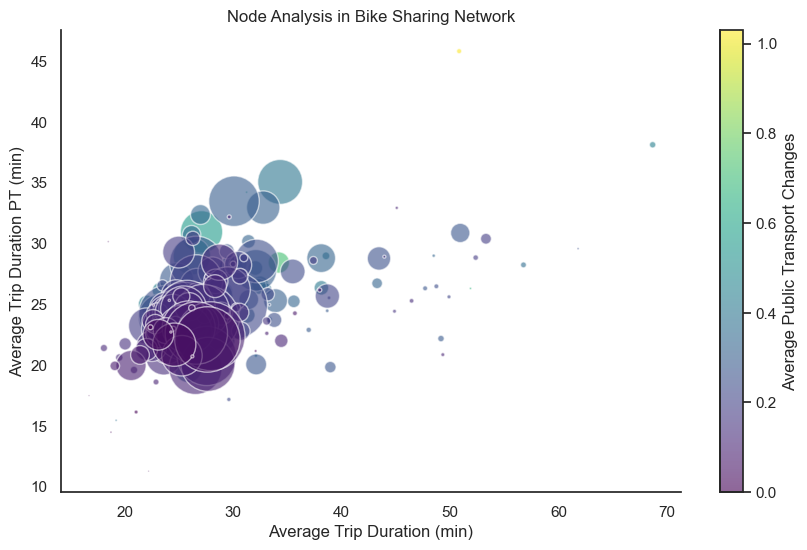

In [139]:
import matplotlib.pyplot as plt

# Assuming 'node_data' is already populated as per your code snippet

# Prepare data
x = [data['avg_trip_duration'] for node, data in sorted_nodes]  # Average Trip Duration
y = [data['avg_trip_duration_pt'] for node, data in sorted_nodes]  # Average Trip Duration PT
sizes = [data['total_trips'] for node, data in sorted_nodes]  # Total Trips for bubble size
colors = [data['avg_changes'] for node, data in sorted_nodes]  # Avg. PubT Changes for color

# Normalize sizes for better visualization
size_norm = [s/2 for s in sizes]  # Adjust the divisor as needed for visual clarity

# Plot
plt.figure(figsize=(10, 6))
bubble = plt.scatter(x, y, s=size_norm, c=colors, cmap='viridis', alpha=0.6, edgecolors='w')

# Add colorbar
cbar = plt.colorbar(bubble)
cbar.set_label('Average Public Transport Changes')

# Labels and titles
plt.xlabel('Average Trip Duration (min)')
plt.ylabel('Average Trip Duration PT (min)')
plt.title('Node Analysis in Bike Sharing Network')

plt.grid(False)
sns.despine()
plt.show()


In [140]:
# Initialize dictionaries to hold the sum of PubTAverageChanges, total trips, and count of trips for aggregation
node_data = {}

for (u, v, data) in G_car.edges(data=True):
    # For each node in the edge, aggregate data
    for node in [u, v]:
        if node not in node_data:
            node_data[node] = {'sum_changes': 0, 'total_trips': 0, 'average_trip duration': 0,'average_trip duration_pt': 0, 'count': 0}
        node_data[node]['sum_changes'] += data.get('PubTAverageChanges', 0)
        node_data[node]['total_trips'] += data.get('TotalTrips', 0)
        # add the average trip duration
        node_data[node]['average_trip duration'] += data.get('AverageTripDurationMin', 0)
        node_data[node]['average_trip duration_pt'] += data.get('PubTAverageDurationMin', 0)

        node_data[node]['count'] += 1

# Calculate average changes per node
for node in node_data:
    node_data[node]['avg_changes'] = node_data[node]['sum_changes'] / node_data[node]['count']
    node_data[node]['avg_trip_duration'] = node_data[node]['average_trip duration'] / node_data[node]['count']
    node_data[node]['avg_trip_duration_pt'] = node_data[node]['average_trip duration_pt'] / node_data[node]['count']
    


In [141]:
# Sort nodes by average changes
sorted_nodes = sorted(node_data.items(), key=lambda x: x[1]['avg_changes'], reverse=True)
#sorted_nodes = sorted_nodes[:20]
# Display the top nodes with the highest average public transport changes
for node, data in sorted_nodes[:20]:  # Adjust the slice as needed
    print(f"Node: {node}, Avg. PubT Changes: {data['avg_changes']:.2f}, Total Trips: {data['total_trips']},Avg. Trip Duration: {data['avg_trip_duration']:.2f}, Avg. Trip Duration PT: {data['avg_trip_duration_pt']:.2f}")
    

Node: Kastrup Lufthavn, Avg. PubT Changes: 1.21, Total Trips: 667,Avg. Trip Duration: 39.86, Avg. Trip Duration PT: 57.35
Node: Ingeniørhøjskolen N, Avg. PubT Changes: 1.14, Total Trips: 1957,Avg. Trip Duration: 35.62, Avg. Trip Duration PT: 49.66
Node: Glostrup syd N, Avg. PubT Changes: 0.97, Total Trips: 1221,Avg. Trip Duration: 37.11, Avg. Trip Duration PT: 50.13
Node: Dragør N, Avg. PubT Changes: 0.95, Total Trips: 539,Avg. Trip Duration: 36.23, Avg. Trip Duration PT: 50.42
Node: DTU S, Avg. PubT Changes: 0.90, Total Trips: 12731,Avg. Trip Duration: 33.56, Avg. Trip Duration PT: 52.23
Node: Ingeniørhøjskolen SV, Avg. PubT Changes: 0.82, Total Trips: 523,Avg. Trip Duration: 38.16, Avg. Trip Duration PT: 50.13
Node: Kongens Lyngby N, Avg. PubT Changes: 0.81, Total Trips: 307,Avg. Trip Duration: 31.76, Avg. Trip Duration PT: 47.12
Node: Rødovre Nord NØ, Avg. PubT Changes: 0.79, Total Trips: 54,Avg. Trip Duration: 26.96, Avg. Trip Duration PT: 35.24
Node: Ingeniørhøjskolen SØ, Avg. Pub

In [142]:
edge_data_car.columns

Index(['StartZoneName', 'EndZoneName', 'AverageTripDurationMin', 'TotalTrips',
       'AvgDistanceKm', 'AverageSpeedKmHr', 'PubTAverageDurationMin',
       'PubTAverageDistanceKm', 'PubTAverageWalkingTimeMin',
       'PubTAverageTransitTimeMin', 'PubTAverageChanges',
       'AvgTripDurationDifference', 'PickupStationProximity',
       'DropoffStationProximity'],
      dtype='object')

In [143]:
import pandas as pd
import plotly.express as px

# Use 'edge_data_bike' or 'edge_data_car' as appropriate
edge_data = edge_data_bike  # or edge_data_car, if you're analyzing car data

# Aggregate data for StartZoneName
start_zone_aggs = edge_data.groupby('StartZoneName').agg({
    'TotalTrips': 'sum',
    'PubTAverageChanges': 'mean',
    'AverageTripDurationMin': 'mean',
    'AvgDistanceKm': 'mean',
    'PubTAverageDurationMin': 'mean',
    'PubTAverageWalkingTimeMin': 'mean',
    'PubTAverageTransitTimeMin': 'mean',
    'AverageSpeedKmHr': 'mean',
    'PickupStationProximity': 'mean',
    'DropoffStationProximity': 'mean'
}).rename(columns=lambda x: x + '_start')

# Aggregate data for EndZoneName
end_zone_aggs = edge_data.groupby('EndZoneName').agg({
    'TotalTrips': 'sum',
    'PubTAverageChanges': 'mean',
    'AverageTripDurationMin': 'mean',
    'AvgDistanceKm': 'mean',
    'PubTAverageDurationMin': 'mean',
    'PubTAverageWalkingTimeMin': 'mean',
    'PubTAverageTransitTimeMin': 'mean',
    'AverageSpeedKmHr': 'mean',
    'PickupStationProximity': 'mean',
    'DropoffStationProximity': 'mean'
}).rename(columns=lambda x: x + '_end')

# Merge StartZoneName and EndZoneName aggregations
node_data = start_zone_aggs.add(end_zone_aggs, fill_value=0).reset_index()

# Compute combined or average metrics as needed for the visualization
node_data['total_trips'] = node_data['TotalTrips_start'] + node_data['TotalTrips_end']
node_data['avg_changes'] = (node_data['PubTAverageChanges_start'] + node_data['PubTAverageChanges_end']) / 2
node_data['avg_trip_duration'] = (node_data['AverageTripDurationMin_start'] + node_data['AverageTripDurationMin_end']) / 2
node_data['avg_distance'] = (node_data['AvgDistanceKm_start'] + node_data['AvgDistanceKm_end']) / 2
node_data['avg_trip_duration_pt'] = (node_data['PubTAverageDurationMin_start'] + node_data['PubTAverageDurationMin_end']) / 2
node_data['avg_trip_duration_diff'] = node_data['avg_trip_duration_pt'] - node_data['avg_trip_duration']
node_data['avg_walking_time_pt'] = (node_data['PubTAverageWalkingTimeMin_start'] + node_data['PubTAverageWalkingTimeMin_end']) / 2
node_data['avg_transit_time_pt'] = (node_data['PubTAverageTransitTimeMin_start'] + node_data['PubTAverageTransitTimeMin_end']) / 2
node_data['avg_speed_km_hr'] = (node_data['AverageSpeedKmHr_start'] + node_data['AverageSpeedKmHr_end']) / 2
node_data['avg_pickup_proximity'] = (node_data['PickupStationProximity_start'] + node_data['PickupStationProximity_end']) / 2
node_data['avg_dropoff_proximity'] = (node_data['DropoffStationProximity_start'] + node_data['DropoffStationProximity_end']) / 2


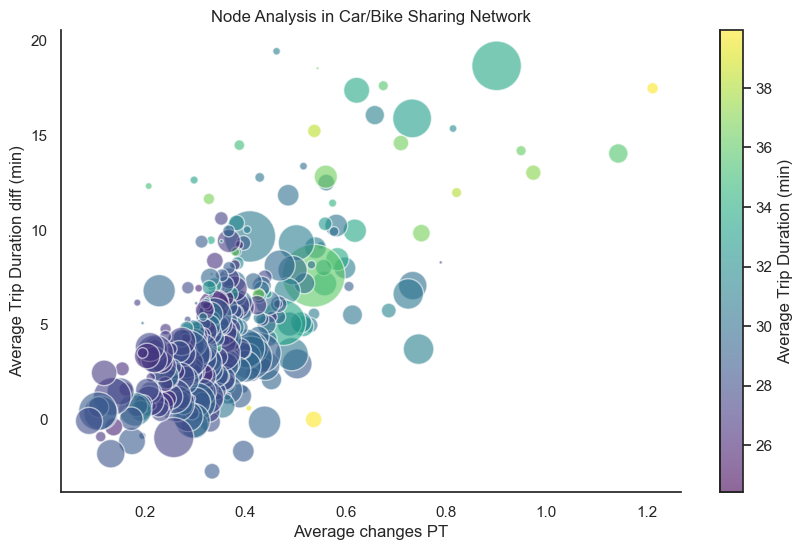

In [144]:
import matplotlib.pyplot as plt

# Assuming 'node_data' is already populated as per your code snippet

# Prepare data
x = [data['avg_trip_duration'] for node, data in sorted_nodes]  # Average Trip Duration
y = [data['avg_trip_duration_pt'] for node, data in sorted_nodes]  # Average Trip Duration PT
diff = [data['avg_trip_duration_pt'] - data['avg_trip_duration'] for node, data in sorted_nodes]  # Difference in durations
sizes = [data['total_trips'] for node, data in sorted_nodes]  # Total Trips for bubble size
colors = [data['avg_changes'] for node, data in sorted_nodes]  # Avg. PubT Changes for color

# Normalize sizes for better visualization
size_norm = [s/10 for s in sizes]  # Adjust the divisor as needed for visual clarity

# Plot
plt.figure(figsize=(10, 6))
bubble = plt.scatter(y = diff, x = colors, s=size_norm, c=x, cmap='viridis', alpha=0.6, edgecolors='w')

# Add colorbar
cbar = plt.colorbar(bubble)
cbar.set_label('Average Trip Duration (min)')

# Labels and titles
plt.ylabel('Average Trip Duration diff (min)')
plt.xlabel('Average changes PT')
plt.title('Node Analysis in Car/Bike Sharing Network')

plt.grid(False)
sns.despine()
plt.show()


In [145]:
import plotly.express as px
import pandas as pd

# Assuming 'sorted_nodes' and 'node_data' are already defined as per your previous code

# Convert sorted_nodes (which is a list of tuples) to a DataFrame for easier handling with Plotly
df = pd.DataFrame([data for node, data in sorted_nodes], index=[node for node, data in sorted_nodes])

# Normalize sizes for Plotly (optional, depending on your size scale)
#df['normalized_total_trips'] = df['total_trips'] / df['total_trips'].max() * 100  # Adjust as needed

# Create the bubble chart
fig = px.scatter(df, x='avg_trip_duration', y='avg_trip_duration_pt',
                 size='total_trips', color='avg_changes',
                 hover_name=df.index,  # Show node names on hover
                 color_continuous_scale='Viridis',  # Color scale
                 labels={'avg_trip_duration': 'Average Trip Duration (min)',
                         'avg_trip_duration_pt': 'Average Trip Duration PT (min)',
                         'avg_changes': 'Average Public Transport Changes',
                         'total_trips': 'Total Trips (Normalized)'},
                 title='Node Analysis in Car/Bike Sharing Network')

# Update layout for clearer visualization
fig.update_layout(autosize=False, width=1200, height=600)
fig.update_traces(marker=dict(line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Show figure
fig.show()


In [146]:
car_df.head()

StartTime             EndTime   UserId  LatitudeStart  \
0 2017-07-01 00:13:04 2017-07-01 00:22:14  82200.0       55.76119   
1 2017-07-01 00:13:18 2017-07-01 00:24:08  82201.0       55.74725   
2 2017-07-01 00:13:31 2017-07-01 00:35:14  82202.0       55.68234   
3 2017-07-01 00:14:18 2017-07-01 00:21:09  82204.0       55.70389   
4 2017-07-01 00:18:34 2017-07-01 01:07:33  82208.0       55.72269   

   LongitudeStart  LatitudeEnd  LongitudeEnd  DistanceKm Month  StartHour  \
0        12.58058     55.77345      12.59096         3.0  July          0   
1        12.56629     55.74989      12.54592         2.0  July          0   
2        12.53219     55.71270      12.57096         5.0  July          0   
3        12.53644     55.70032      12.53879         2.0  July          0   
4        12.48417     55.66177      12.60801        11.0  July          0   

    Weekday  TripDurationMin  SpeedKmHr  PubTDurationMin  PubTDistanceKm  \
0  Saturday         9.166667  19.636364        20.966667         2.97314   
1  Saturday        10.833333  11.076923        20.483333         1.54651   
2  Saturday        21.716667  13.814275        29.700000         7.00555   
3  Saturday         6.850000  17.518248         7.100000         0.52118   
4  Saturday        48.983333  13.473971        45.633333        13.52227   

   PubTWalkingTimeMin  PubTTransitTimeMin  PubTChanges  \
0           17.966667                 3.0          0.0   
1           20.483333                 0.0          0.0   
2           17.700000                12.0          0.0   
3            7.100000                 0.0          0.0   
4           15.100000                27.0          1.0   

   PickupStationProximity  DropoffStationProximity      UserCategory  \
0                  381.15                   883.53  Occasional Users   
1                 1546.51                  1546.51  Occasional Users   
2                  248.86                   702.45  Occasional Users   
3                  521.18                   521.18  Occasional Users   
4                   80.13                   486.33  Occasional Users   

   StartZoneId           StartZoneName          StartZoneDescri  EndZoneId  \
0     157123.0       Charlottenlund NØ         Gentofte Kommune   157111.0   
1     157151.0  Bernstorffsvej Station         Gentofte Kommune   157213.0   
2     147162.0  Frederiksberg Øst NV S    Frederiksberg Kommune   102324.0   
3     102541.0            Utterslev NØ  Københavns Kommune Nord   102452.0   
4     102671.0             Tingbjerg N  Københavns Kommune Nord   103172.0   

           EndZoneName               EndZoneDescri  StartZoneCounts  \
0        Klampenborg Ø            Gentofte Kommune            710.0   
1          Gentofte SØ            Gentofte Kommune            945.0   
2  Svanemøllen Station     Københavns Kommune Nord           3056.0   
3     Ydre Nørrebro NV     Københavns Kommune Nord           3629.0   
4   Sundbyøster Nord V  Københavns Kommune, Amager            397.0   

   EndZoneCounts  TripDurationDiff Mode  TripDurationDifference  
0          553.0         11.800000  car               11.800000  
1          726.0          9.650000  car                9.650000  
2         2075.0          7.983333  car                7.983333  
3         2316.0          0.250000  car                0.250000  
4         3903.0         -3.350000  car               -3.350000

In [147]:
edge_data_bike.head()

StartZoneName          EndZoneName  AverageTripDurationMin  \
0  Amager Fælled nord  Amager Strandpark N               21.769504   
1  Amager Fælled nord           Amagertorv               18.533285   
2  Amager Fælled nord         Amagerværket               46.506974   
3  Amager Fælled nord        Amalienborg Ø               25.517634   
4  Amager Fælled nord      Bella Centret V               20.663591   

   TotalTrips  AvgDistanceKm  AverageSpeedKmHr  PubTAverageDurationMin  \
0           2       4.228218          8.544064               37.000000   
1          36       2.137185         10.711721               28.073148   
2           1       3.984560          3.999400               40.266667   
3           6       2.871032          7.725212               34.327778   
4           4       2.856438          9.174718               23.750000   

   PubTAverageDistanceKm  PubTAverageWalkingTimeMin  \
0               5.749420                  23.166667   
1               3.933080                  19.692593   
2               5.226230                  11.150000   
3               3.875563                  20.488889   
4               4.255805                  15.491667   

   PubTAverageTransitTimeMin  PubTAverageChanges  AvgTripDurationDifference  \
0                   9.833333            0.000000                  15.230496   
1                   7.777778            0.083333                   9.539863   
2                  23.000000            1.000000                  -6.240307   
3                  12.833333            0.166667                   8.810144   
4                   7.250000            0.250000                   3.086409   

   PickupStationProximity  DropoffStationProximity  InverseAvgDuration  
0              694.030000               826.620000            0.045936  
1              571.471667               743.123889            0.053957  
2              310.530000               207.070000            0.021502  
3              751.501667               492.511667            0.039189  
4              325.312500               711.670000            0.048394

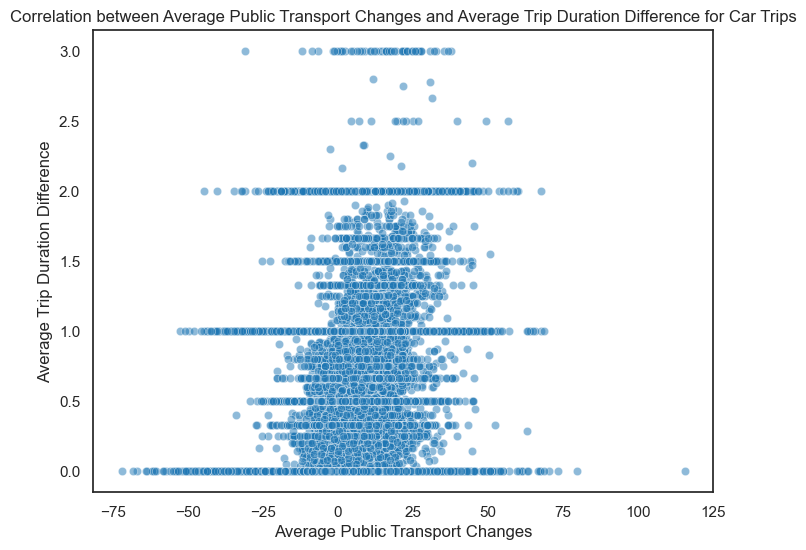

In [148]:
edge_data_car[['PubTAverageChanges', 'AvgTripDurationDifference']].corr()

# plot the correlation between the average trip duration difference and the average public transport changes for car trips
plt.figure(figsize=(8, 6))
sns.scatterplot(data=edge_data_car, y='PubTAverageChanges', x='AvgTripDurationDifference', alpha=0.5)
plt.title('Correlation between Average Public Transport Changes and Average Trip Duration Difference for Car Trips')
plt.xlabel('Average Public Transport Changes')
plt.ylabel('Average Trip Duration Difference')
plt.show()

In [149]:
# in the bike_df print the correlation between changes and trip duration
car_df[['PubTChanges', 'TripDurationDifference']].corr()

PubTChanges  TripDurationDifference
PubTChanges                  1.0000                  0.1983
TripDurationDifference       0.1983                  1.0000

In [150]:
# group by cnage and calculate the average trip duration
bike_df.groupby('PubTChanges')[['TripDurationMin', "PubTDurationMin"]].mean()


TripDurationMin  PubTDurationMin
PubTChanges                                  
0.0                22.210450        21.330571
1.0                30.237072        30.013619
2.0                35.896626        38.049553

In [151]:
# see nodes wit hthe highest AvgPubTChanges for bike trips abd the coresponding TotalTrips
highest_changes = sorted(G_bike.edges(node, data=True), reverse=False)
# access nodes with the highest AvgPubTChanges in the edge data for bike trips
highest_changes 

[('Sundbyøster Syd Midt',
  'Amager Strandpark N',
  {'AverageTripDurationMin': 8.706249613888888,
   'TotalTrips': 12,
   'AvgDistanceKm': 1.1178550581057005,
   'AverageSpeedKmHr': 29.312480849870166,
   'PubTAverageDurationMin': 11.911111111111111,
   'PubTAverageDistanceKm': 1.6208883333333333,
   'PubTAverageWalkingTimeMin': 9.16111111111111,
   'PubTAverageTransitTimeMin': 2.75,
   'PubTAverageChanges': 0.0,
   'AvgTripDurationDifference': 3.204861497222222,
   'PickupStationProximity': 153.77333333333334,
   'DropoffStationProximity': 518.5133333333333,
   'InverseAvgDuration': 0.114860006258575}),
 ('Sundbyøster Syd Midt',
  'Amagertorv',
  {'AverageTripDurationMin': 27.76117212777778,
   'TotalTrips': 3,
   'AvgDistanceKm': 3.646730407457898,
   'AverageSpeedKmHr': 6.94653923628502,
   'PubTAverageDurationMin': 30.79444444444444,
   'PubTAverageDistanceKm': 5.505610000000001,
   'PubTAverageWalkingTimeMin': 19.25,
   'PubTAverageTransitTimeMin': 8.166666666666666,
   'PubTAver

Based on the communities you've identified in the Copenhagen bike network, we can make several observations and draw conclusions about urban mobility and cycling patterns within the city. The communities you've listed show distinct groupings of zones that are likely connected by frequent cycling routes and shared characteristics. Here's a closer look at each community and potential implications:

### Community 1: Central Copenhagen and Surrounding Areas
- **Characteristics**: This community encompasses zones around central Copenhagen, including major landmarks (Amagertorv, Christiansborg), waterfront areas (Amager Strandpark, Islands Brygge), and transport hubs (Kastrup Lufthavn).
- **Implications**: It represents the core cycling area within Copenhagen, likely reflecting both daily commuting patterns and leisure cycling. The presence of key cultural and governmental institutions, along with recreational areas, suggests a high integration of cycling into daily life and tourism.

### Community 2: Northern and Eastern Suburbs
- **Characteristics**: Includes areas like Hellerup, Gentofte, and the vicinity of the University Park and Rigshospitalet. It covers both residential suburbs and key educational and healthcare institutions.
- **Implications**: This community might indicate zones with significant commuting to educational and healthcare facilities, showcasing the role of cycling in connecting residential areas with major city services and institutions.

### Community 3: Western Suburbs and Transition Zones
- **Characteristics**: Features areas like Frederiksberg, Bispebjerg, and parts of Vesterbro, including major parks (Frederiksberg Have) and shopping areas (Fisketorvet).
- **Implications**: Reflects the integration of cycling in residential neighborhoods and commercial districts, facilitating access to green spaces, shopping, and leisure destinations.

### Community 4: Outlying Areas and Specific Institutions
- **Characteristics**: Smaller in size, this community includes outlying areas and specific institutions like DTU (Technical University of Denmark), highlighting the focused use of cycling around educational campuses and potentially less dense residential areas.
- **Implications**: Indicates the importance of cycling connectivity for educational institutions, even in less central locations, supporting student and faculty mobility.

### General Conclusions:
- **Comprehensive Cycling Network**: The distribution of communities underscores the comprehensive nature of Copenhagen's cycling network, connecting central areas, suburbs, and specific institutions effectively.
- **Varied Cycling Needs**: The distinct communities reflect the varied cycling needs across the city—from daily commuting and student mobility to leisure and tourism.
- **Infrastructure Planning**: Understanding these communities can guide infrastructure planning, highlighting areas where cycling connectivity can be enhanced or where additional facilities might be needed.
- **Sustainability and Quality of Life**: The evident integration of cycling throughout Copenhagen supports the city's sustainability goals and contributes to high quality of life by promoting active transportation and reducing reliance on motor vehicles.

These communities paint a picture of a city where cycling is deeply woven into the urban fabric, supporting diverse mobility needs and enhancing Copenhagen's status as a bike-friendly city.

With the corrected approach, the community detection algorithm identified **3 communities** in each of the bike and car transportation networks. This result suggests a notable level of structural organization within Copenhagen's transportation network, with distinct clusters of zones that are more densely connected to each other than to the rest of the network.

### Interpretation of Results:

1. **Distinct Transportation Preferences or Needs**: The existence of 3 distinct communities within both the bike and car networks may reflect areas of Copenhagen with unique transportation preferences, needs, or infrastructural setups. These communities could be characterized by similar usage patterns, geographic proximity, or shared socio-economic factors that influence how residents and visitors choose to travel.

2. **Urban Planning and Infrastructure Design**: Identifying these communities can provide valuable insights for urban planners and transportation authorities. Understanding the clustering of trips and the characteristics of these clusters can help in tailoring infrastructure improvements, services, and policies to the specific needs and behaviors of different parts of the city.

3. **Network Efficiency and Connectivity**: The delineation of communities within the transportation network also has implications for assessing network efficiency and connectivity. It can highlight potential areas where connectivity between communities might be improved or where investment in transportation infrastructure can have the most significant impact on enhancing mobility across the city.

4. **Comparative Analysis**: Having the same number of communities in both bike and car networks suggests a level of similarity in the spatial organization of trips across these modes. However, the specific composition of these communities—such as which zones fall into each community—could differ, reflecting the unique aspects of bike versus car transportation. Further analysis could reveal how these communities overlap or diverge between modes, providing deeper insights into multimodal transportation dynamics in Copenhagen.

This finding lays the groundwork for more detailed exploration of each community, including analyzing the geographic distribution of communities, the characteristics of trips within and between them, and the potential for enhancing intermodal connectivity.

**Are there specific times of day when bike or car trips are significantly faster or slower than public transport?** Identify if there are peak hours where one mode outperforms the others in terms of travel time.

In [167]:
# group by the SartHour column in bike_df and calculate the average trip duration and the total number of trips
hourly_bike = bike_df.groupby('StartHour').agg(AvgTripDurationMin=('TripDurationMin', 'mean'),
                                          # public transport
                                            PubTAvgDurationMin=('PubTDurationMin', 'mean'),
                                            AvgDistanceKm=("DistanceKm", 'mean'),
                                            AvgPubTDistanceKm=("PubTDistanceKm", 'mean'),
                                            TotalTrips=('TripDurationMin', 'count')).reset_index()
hourly_bike

StartHour  AvgTripDurationMin  PubTAvgDurationMin  AvgDistanceKm  \
0           0           21.399971           22.235642       2.537909   
1           1           20.372467           22.658005       2.510019   
2           2           20.279496           21.886546       2.451458   
3           3           20.933815           22.768941       2.635976   
4           4           20.183350           21.850910       2.581696   
5           5           21.115348           23.242753       2.881931   
6           6           20.437051           23.275837       2.773376   
7           7           20.989532           23.403721       2.717137   
8           8           22.572969           22.384694       2.585286   
9           9           25.498164           22.518740       2.602789   
10         10           25.698326           22.315750       2.590435   
11         11           25.243527           22.544516       2.597079   
12         12           25.485008           22.373765       2.546162   
13         13           25.665059           22.562847       2.609262   
14         14           25.135383           23.091532       2.665391   
15         15           23.966916           23.028790       2.608202   
16         16           23.554396           22.958142       2.609694   
17         17           22.998715           22.302099       2.542179   
18         18           23.020892           22.159199       2.548503   
19         19           22.629827           21.656315       2.517988   
20         20           21.930285           21.226375       2.530388   
21         21           21.670186           21.102988       2.503016   
22         22           20.667789           21.224068       2.472920   
23         23           21.280144           21.473176       2.551095   

    AvgPubTDistanceKm  TotalTrips  
0            3.940010        1321  
1            3.953761        1091  
2            3.774586         799  
3            4.156398         535  
4            4.000559         513  
5            4.407170        1435  
6            4.287269        3904  
7            4.262566        4945  
8            4.020690        3933  
9            3.973498        3906  
10           3.962517        3910  
11           3.977004        3784  
12           3.873580        3921  
13           3.977670        4398  
14           4.077909        5576  
15           4.034774        6578  
16           4.008575        6475  
17           3.897666        5447  
18           3.917335        4426  
19           3.886458        4043  
20           3.873335        3485  
21           3.830217        3163  
22           3.810069        2450  
23           3.935498        1859

In [153]:
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
# Set the default template
pio.templates.default = "plotly_white"

In [177]:
import plotly.graph_objects as go

# Assuming 'hourly_bike' is your DataFrame
# Create figure with secondary y-axis
fig = go.Figure()

# Add Avg. Trip Duration trace
fig.add_trace(go.Scatter(x=hourly_bike['StartHour'], y=hourly_bike['AvgTripDurationMin'],
                         name='Avg. Bike Trip Duration', line=dict(color='#1f77b4',width=3)))

# Add Avg. Public Transport Duration trace
fig.add_trace(go.Scatter(x=hourly_bike['StartHour'], y=hourly_bike['PubTAvgDurationMin'],
                         name='Avg. Public Transport Duration', line=dict(color='purple',width=3)))

# Add Avg. Trip Distance trace on secondary y-axis
fig.add_trace(go.Scatter(x=hourly_bike['StartHour'], y=hourly_bike['AvgDistanceKm'],
                         name='Avg. Bike Trip Distance', line=dict(color='#1f77b4',width=3, dash='dash'),
                         yaxis='y2'))  # This assigns the trace to the secondary y-axis

# Add Avg. Trip Distance trace on secondary y-axis
fig.add_trace(go.Scatter(x=hourly_bike['StartHour'], y=hourly_bike['AvgPubTDistanceKm'],
                         name='Avg. Public Transport Trip Distance', line=dict(color='purple',width=3, dash='dash'),
                         yaxis='y2'))

# Update layout to support secondary y-axis for distance
fig.update_layout(
    xaxis=dict(title='Start Hour', titlefont=dict(size=18),tickfont=dict(size=16)),
    yaxis=dict(title='Duration (min)', titlefont=dict(size=18), tickfont=dict(size=16)),
    yaxis2=dict(title='Distance (km)', titlefont=dict(size=18), tickfont=dict(size=16),
                overlaying='y', side='right'),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5, font=dict(size=16)),
    template='plotly_white',
    margin=dict(l=20, r=20, t=100, b=20),
    width=1000, height=500,
)

fig.show()


In [155]:
# Compare the average trip duration between bikes and public transport in rush hours and non-rush hours
rush_hour_bike = bike_df.query('StartHour in [7, 8, 9, 15, 16, 17]')
non_rush_hour_bike = bike_df.query('StartHour not in [7, 8, 9, 15, 16, 17]')
print("Rush hour comparison - Bike:", rush_hour_bike['TripDurationMin'].mean(), ", Public Tr:", rush_hour_bike['PubTDurationMin'].mean())
print("Non rush hour comparison:", non_rush_hour_bike['TripDurationMin'].mean(), non_rush_hour_bike['PubTDurationMin'].mean())


Rush hour comparison - Bike: 23.25826742366439 , Public Tr: 22.802246622341556
Non rush hour comparison: 23.23210499809436 22.24225693003774


In [178]:
# group by the SartHour column in car_df and calculate the average trip duration and the total number of trips
hourly_car = car_df.groupby('StartHour').agg(AvgTripDurationMin=('TripDurationMin', 'mean'),
                                          # public transport
                                            PubTAvgDurationMin=('PubTDurationMin', 'mean'),
                                            AvgDistanceKm=("DistanceKm", 'mean'),
                                            AvgPubTDistanceKm=("PubTDistanceKm", 'mean'),
                                            TotalTrips=('TripDurationMin', 'count')).reset_index()
hourly_car

StartHour  AvgTripDurationMin  PubTAvgDurationMin  AvgDistanceKm  \
0           0           23.043416           32.846438       7.263140   
1           1           22.065978           33.799199       7.109582   
2           2           22.315316           33.889116       7.359388   
3           3           24.331874           35.689013       8.390702   
4           4           25.973504           37.115210       9.776749   
5           5           26.774375           35.669062       9.462273   
6           6           28.462532           34.636127       8.518631   
7           7           31.200708           34.042601       8.061283   
8           8           28.677375           32.399738       7.472767   
9           9           26.323508           32.125747       7.733632   
10         10           26.290828           31.156173       7.366281   
11         11           27.054921           31.215526       7.434816   
12         12           27.269451           31.314302       7.561398   
13         13           27.367700           30.935478       7.434394   
14         14           28.443549           31.463770       7.502154   
15         15           29.476770           31.482193       7.438449   
16         16           29.364907           31.417388       7.454612   
17         17           27.957787           31.125555       7.393782   
18         18           26.296059           30.535577       7.268232   
19         19           25.265699           30.154624       7.238936   
20         20           24.569575           30.025421       7.232116   
21         21           24.405218           30.051679       7.324878   
22         22           24.245356           30.663529       7.489033   
23         23           23.745652           30.714170       7.325598   

    AvgPubTDistanceKm  TotalTrips  
0            7.127721        6012  
1            6.961366        3705  
2            7.094865        2418  
3            8.286514        2022  
4            9.798749        2701  
5            9.505411        4188  
6            8.766491        7917  
7            8.260152       15812  
8            7.644733       19976  
9            7.663903       17656  
10           7.205893       15125  
11           7.232990       16791  
12           7.295861       18315  
13           7.169782       19457  
14           7.290939       20896  
15           7.290521       23834  
16           7.281336       27485  
17           7.201079       30169  
18           7.016403       26231  
19           6.949880       21805  
20           6.968707       19529  
21           7.014960       16794  
22           7.182249       14179  
23           7.076064        9653

In [179]:
fig = go.Figure()

# Add Avg. Trip Duration trace
fig.add_trace(go.Scatter(x=hourly_car['StartHour'], y=hourly_car['AvgTripDurationMin'],
                         name='Avg. Car Trip Duration', line=dict(color='#1f77b4',width=3)))

# Add Avg. Public Transport Duration trace
fig.add_trace(go.Scatter(x=hourly_car['StartHour'], y=hourly_car['PubTAvgDurationMin'],
                         name='Avg. Public Transport Duration', line=dict(color='purple',width=3)))

# Add Avg. Trip Distance trace on secondary y-axis
fig.add_trace(go.Scatter(x=hourly_car['StartHour'], y=hourly_car['AvgDistanceKm'],
                         name='Avg. Car Trip Distance', line=dict(color='#1f77b4',width=3, dash='dash'),
                         yaxis='y2'))  # This assigns the trace to the secondary y-axis

# Add Avg. Trip Distance trace on secondary y-axis
fig.add_trace(go.Scatter(x=hourly_car['StartHour'], y=hourly_car['AvgPubTDistanceKm'],
                         name='Avg. Public Transport Trip Distance', line=dict(color='purple',width=3, dash='dash'),
                         yaxis='y2'))

fig.update_layout(
    xaxis=dict(title='Start Hour', titlefont=dict(size=18),tickfont=dict(size=16)),
    yaxis=dict(title='Duration (min)', titlefont=dict(size=18), tickfont=dict(size=16)),
    yaxis2=dict(title='Distance (km)', titlefont=dict(size=18), tickfont=dict(size=16),
                overlaying='y', side='right'),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5, font=dict(size=16)),
    template='plotly_white',
    margin=dict(l=20, r=20, t=100, b=20),
    width=1000, height=500,
)

fig.show()

In [158]:
# Compare the average trip duration between cars and public transport in rush hours and non-rush hours
rush_hour_car = car_df.query('StartHour in [6, 7, 8, 15, 16, 17]')
non_rush_hour_car = car_df.query('StartHour not in [6, 7, 8, 15, 16, 17]')
print("Rush hour comparison - Car:", rush_hour_car['TripDurationMin'].mean(),", Public Tr:", rush_hour_car['PubTDurationMin'].mean())
print("Non rush hour comparison - Car: ", non_rush_hour_car['TripDurationMin'].mean(),", Public Tr:", non_rush_hour_car['PubTDurationMin'].mean())

Rush hour comparison - Car: 29.112210613479455 , Public Tr: 32.05125965509254
Non rush hour comparison - Car:  25.906014687738182 , Public Tr: 31.172458876719276


In [159]:
# create new bool col in car_df called RushHour and set it to True if StartHour is in [6, 7, 8, 15, 16, 17] else False
car_df['RushHour'] = car_df['StartHour'].isin([6, 7, 8, 15, 16, 17])


In [160]:
# convert RushHour to category
car_df['RushHour'] = car_df['RushHour'].astype('category')
# value counts of RushHour
car_df['RushHour'].value_counts()

RushHour
False    237477
True     125193
Name: count, dtype: int64

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



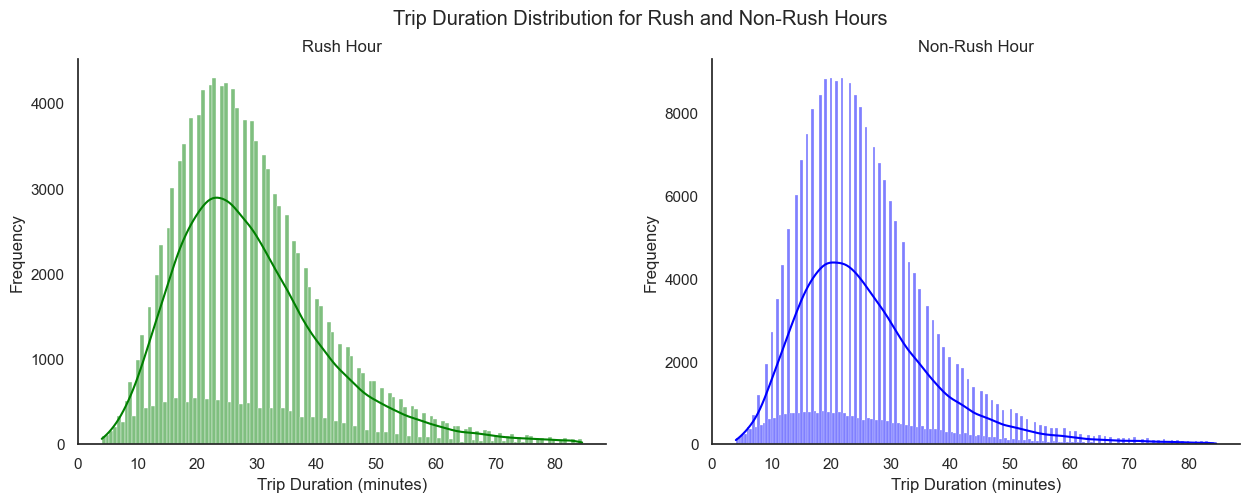

In [161]:
# plot the distribution of trip durations for rush and non-rush hours as histograms
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Trip Duration Distribution for Rush and Non-Rush Hours')
sns.histplot(rush_hour_car['TripDurationMin'], kde=True, ax=axes[0], color='green', label='Rush Hour')
sns.histplot(non_rush_hour_car['TripDurationMin'], kde=True, ax=axes[1], color='blue', label='Non-Rush Hour')
axes[0].set_title('Rush Hour')
axes[1].set_title('Non-Rush Hour')
axes[0].set_xlabel('Trip Duration (minutes)')
axes[1].set_xlabel('Trip Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[1].set_ylabel('Frequency')
sns.despine()
plt.show()


In [162]:
car_df['RushHour'] = car_df['RushHour'].astype('bool')

In [163]:


all_results = pd.DataFrame()

# Since RushHour is likely a boolean, we don't have a '.unique()' method to iterate over directly.
# Instead, define the conditions explicitly:
rush_hour_conditions = [True, False]  # Assuming 'True' represents rush hour, 'False' for non-rush hour

for is_rush_hour in rush_hour_conditions:
    subset = car_df[car_df['RushHour'] == is_rush_hour]
    
    # Depending on how you define rush hour in your dataset, you might need to adjust the above condition.
    print(f"Rush Hour: {is_rush_hour}", subset[['TripDurationMin', 'PubTDurationMin']].mean())
    
    # Perform a paired t-test or Wilcoxon signed-rank test
    df = pg.ttest(subset['TripDurationMin'], subset['PubTDurationMin'], paired=True, alternative='two-sided').round(3)
    
    # Add a column to 'df' indicating the current rush hour condition before concatenating
    df['RushHour'] = is_rush_hour
    all_results = pd.concat([all_results, df], ignore_index=True)

# Display the results
all_results


Rush Hour: True TripDurationMin    29.112211
PubTDurationMin    32.051260
dtype: float64


NameError: name 'pg' is not defined

In [ ]:
# Filter the DataFrame into rush hour and non-rush hour groups
rush_hour_df = car_df[car_df['RushHour']]
non_rush_hour_df = car_df[~car_df['RushHour']]

In [ ]:
from scipy.stats import ttest_rel, wilcoxon
# Assuming normality for demonstration
t_stat_non_rush, p_value_non_rush = ttest_rel(non_rush_hour_df['TripDurationMin'], non_rush_hour_df['PubTDurationMin'])

# For non-normal distributions
# stat_non_rush, p_value_non_rush = wilcoxon(non_rush_hour_df['TripDurationMin'], non_rush_hour_df['PubTDurationMin'])

print(f"Non-Rush Hour Comparison - Paired T-Test T-Stat: {t_stat_non_rush}, P-Value: {p_value_non_rush}")


Non-Rush Hour Comparison - Paired T-Test T-Stat: -197.88616566721285, P-Value: 0.0


In [ ]:
# Assuming normality for demonstration
t_stat_non_rush, p_value_non_rush = ttest_rel(rush_hour_df['TripDurationMin'], rush_hour_df['PubTDurationMin'])

# For non-normal distributions
# stat_non_rush, p_value_non_rush = wilcoxon(non_rush_hour_df['TripDurationMin'], non_rush_hour_df['PubTDurationMin'])

print(f"Non-Rush Hour Comparison - Paired T-Test T-Stat: {t_stat_non_rush}, P-Value: {p_value_non_rush}")


Non-Rush Hour Comparison - Paired T-Test T-Stat: -79.68396265206755, P-Value: 0.0


In [ ]:
car_df.columns

Index(['StartTime', 'EndTime', 'UserId', 'LatitudeStart', 'LongitudeStart',
       'LatitudeEnd', 'LongitudeEnd', 'DistanceKm', 'Month', 'StartHour',
       'Weekday', 'TripDurationMin', 'SpeedKmHr', 'PubTDurationMin',
       'PubTDistanceKm', 'PubTWalkingTimeMin', 'PubTTransitTimeMin',
       'PubTChanges', 'PickupStationProximity', 'DropoffStationProximity',
       'UserCategory', 'StartZoneId', 'StartZoneName', 'StartZoneDescri',
       'EndZoneId', 'EndZoneName', 'EndZoneDescri', 'StartZoneCounts',
       'EndZoneCounts', 'TripDurationDiff', 'Mode', 'TripDurationDifference',
       'RushHour'],
      dtype='object')

In [ ]:
import pandas as pd
import pingouin as pg

# Assuming car_df is your original DataFrame

# Melt the DataFrame to long format suitable for pairwise_tests
long_df = pd.melt(car_df, id_vars=['StartHour', 'RushHour'], 
                  value_vars=['TripDurationMin', 'PubTDurationMin'],
                  var_name='TransportMode', value_name='DurationMin')

# Map the original variable names to more descriptive ones
long_df['TransportMode'] = long_df['TransportMode'].map({
    'TripDurationMin': 'Car',
    'PubTDurationMin': 'PublicTransport'
})

# Now you can use pairwise_tests to compare the durations
# Make sure to specify the interaction between TransportMode and RushHour
results = pg.pairwise_tests(data=long_df[long_df['RushHour']], dv='DurationMin', between='TransportMode', padjust='bonf')
results


C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning:

divide by zero encountered in scalar divide



Contrast    A                B  Paired  Parametric          T  \
0  TransportMode  Car  PublicTransport   False        True -59.796863   

        dof alternative  p-unc BF10    hedges  
0  250384.0   two-sided    0.0  inf -0.239002

In [ ]:
results = pg.pairwise_tests(data=long_df[long_df['RushHour']==False], dv='DurationMin', within='TransportMode', padjust='bonf')
results

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning:

divide by zero encountered in divide

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\scipy\stats\_stats_py.py:1103: RuntimeWarning:

invalid value encountered in scalar multiply

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\parametric.py:243: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning:

Degrees of freedom <= 0 for slice

c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning:

invalid value encountered in scalar divide



Contrast    A                B  Paired  Parametric  dof alternative  \
0  TransportMode  Car  PublicTransport    True        True  0.0   two-sided   

  BF10  
0  nan

In [ ]:
len(long_df)

725340

In [ ]:
results = pg.pairwise_tests(data=melted_df, dv='DurationMin', between=['TransportMode', 'RushHour'], padjust='bonf')
results

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\pairwise.py:593: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perfo

Contrast    TransportMode      A                B Paired  \
0             TransportMode                -    Car  PublicTransport  False   
1                  RushHour                -  False             True  False   
2  TransportMode * RushHour              Car  False             True  False   
3  TransportMode * RushHour  PublicTransport  False             True  False   

  Parametric           T            dof alternative          p-unc  \
0       True -157.793685  725338.000000   two-sided   0.000000e+00   
1       True  -67.275282  499802.216327   two-sided   0.000000e+00   
2       True  -72.713044  235380.323368   two-sided   0.000000e+00   
3       True  -21.635592  259271.505747   two-sided  1.026863e-103   

          p-corr p-adjust       BF10    hedges  
0            NaN      NaN        inf -0.370551  
1            NaN      NaN        inf -0.167271  
2   0.000000e+00     bonf        inf -0.261220  
3  2.053725e-103     bonf  1.485e+99 -0.075085

In [ ]:
# use pairwise non parametric test to compare the trip duration between rush and non-rush hours with pingouin
import pingouin as pg
results = pg.pairwise_tests(dv='TripDurationMin', between='RushHour', data=car_df, padjust='bonf')
results

C:\Users\mihai\AppData\Roaming\Python\Python311\site-packages\pingouin\bayesian.py:152: RuntimeWarning:

divide by zero encountered in scalar divide



Contrast      A     B  Paired  Parametric          T            dof  \
0  RushHour  False  True   False        True -72.713044  235380.323368   

  alternative  p-unc BF10   hedges  
0   two-sided    0.0  inf -0.26122

In [ ]:
edge_df = nx.to_pandas_edgelist(G_bike)
edge_df.rename(columns={'source': 'from', 'target': 'to'}, inplace=True)
edge_df.head()

from                   to  DropoffStationProximity  AvgDistanceKm  \
0  Esplanaden   Amager Fælled nord                 1179.944       3.630060   
1  Esplanaden  Amager Strandpark N                  395.090       3.795487   
2  Esplanaden           Amagertorv                  712.047       1.344495   
3  Esplanaden        Amalienborg Ø                 1014.920       0.693836   
4  Esplanaden        Bispebjerg SØ                  528.010       4.289135   

   PubTAverageDistanceKm  PubTAverageChanges  AvgTripDurationDifference  \
0               5.531586                 0.2                  12.328137   
1               6.363720                 0.0                 -44.556663   
2               1.753935                 0.0                   1.692297   
3               1.014920                 0.0                   2.126755   
4               7.316610                 0.0                 -58.489037   

   InverseAvgDuration  PubTAverageWalkingTimeMin  PickupStationProximity  \
0            0.037755                  27.428333                 639.709   
1            0.012961                  18.600000                 680.590   
2            0.061108                  16.256667                 792.461   
3            0.085240                  13.858333                1014.920   
4            0.011059                  20.933333                 680.590   

   PubTAverageDurationMin  TotalTrips  AverageTripDurationMin  \
0               38.815000          10               26.486863   
1               32.600000           1               77.156663   
2               18.056667          10               16.364370   
3               13.858333           2               11.731578   
4               31.933333           1               90.422370   

   PubTAverageTransitTimeMin  AverageSpeedKmHr  
0                        8.3          7.244760  
1                        9.0          2.410680  
2                        1.8         12.462631  
3                        0.0         22.508520  
4                       11.0          2.057013

In [ ]:
# save edge_df to a csv file
edge_df.to_csv('../data/processed/edge_df_bike.csv', index=False)

In [ ]:
node_df = pd.DataFrame(list(G_bike.nodes(data=True)))
node_df.reset_index(drop=True, inplace=True)
node_df['id'] = node_df[0]
node_df.drop(columns=[0,1], inplace=True)
node_df.head()
#node_df['node'] = node_df['node'].apply(lambda x: str(x))  # Ensure node identifiers are strings for compatibility

id
0                Esplanaden
1  Københavns Hovedbanegård
2           Ydre Nørrebro S
3              Vesterbro SV
4                    Tivoli

In [ ]:
# compute the harmonic centrality and indentify the 5 nodes with the highest harmonic centrality
harmonic_centrality = nx.harmonic_centrality(G_bike)
sorted(harmonic_centrality.items(), key=lambda x: x[1], reverse=True)[:5]


[('Kgs. Nytorv', 186.33333333333334),
 ('Amagertorv', 184.66666666666669),
 ('Rådhuspladsen', 184.1666666666667),
 ('Rundetårn', 182.33333333333334),
 ('Vesterport Station Ø', 181.66666666666669)]

In [ ]:
sorted(harmonic_centrality.items(), key=lambda x: x[1], reverse=False)[:5]

[('Hellerup V', 78.24999999999999),
 ('Tårnby Ø', 78.58333333333333),
 ('Ydre Østerbro SV', 82.33333333333327),
 ('DTU S', 82.41666666666659),
 ('Vestamager Ø', 84.99999999999987)]

In [ ]:
edge_data_bike.columns

Index(['StartZoneName', 'EndZoneName', 'AverageTripDurationMin', 'TotalTrips',
       'AvgDistanceKm', 'AverageSpeedKmHr', 'PubTAverageDurationMin',
       'PubTAverageDistanceKm', 'PubTAverageWalkingTimeMin',
       'PubTAverageTransitTimeMin', 'PubTAverageChanges',
       'AvgTripDurationDifference', 'PickupStationProximity',
       'DropoffStationProximity', 'InverseAvgDuration'],
      dtype='object')

In [ ]:
# compute the eigenvector centrality and indentify the 5 nodes with the highest eigenvector centrality
eigenvector_centrality_bike = nx.eigenvector_centrality(G_bike)
sorted(eigenvector_centrality_bike.items(), key=lambda x: x[1], reverse=True)[:10]

[('Kgs. Nytorv', 0.12302617373635301),
 ('Amagertorv', 0.12078381648328367),
 ('Rådhuspladsen', 0.1207440149584718),
 ('Rundetårn', 0.11992091116849342),
 ('Vesterbro N', 0.11804702607789512),
 ('Nørreport', 0.11754678671527066),
 ('Vesterport Station Ø', 0.11704639106566435),
 ('Københavns Hovedbanegård', 0.11676411539033874),
 ('Indre Nørrebro Ø', 0.11675896125113182),
 ('Vesterbro Midt', 0.11663041809911961)]

In [ ]:
# compute the eigenvector centrality and indentify the 5 nodes with the highest eigenvector centrality
eigenvector_centrality_car = nx.eigenvector_centrality(G_car)
sorted(eigenvector_centrality_car.items(), key=lambda x: x[1], reverse=True)[:10]


[('Kastrup Lufthavn Udenrigs', 0.08135370816902358),
 ('Dronningens Tværgade', 0.08058414194354895),
 ('Indre Østerbro N', 0.08012265593248043),
 ('Utterslev NØ', 0.0790591380796759),
 ('Christianshavn S', 0.0787341805799244),
 ('Pisserenden', 0.07871452715005747),
 ('Vesterport Station V', 0.078422989254274),
 ('Indre Nørrebro SØ', 0.07840050167354734),
 ('Ørestaden Metrostation', 0.07821474411008936),
 ('Rundetårn', 0.07800862971210348)]

In [ ]:
# using car_df, groupby the StartZoneName and print the top 10 nodes with the highest SpeedKmHr
car_df.groupby('EndZoneName')['SpeedKmHr'].mean().sort_values(ascending=False)[:10]

EndZoneName
Høje Taastrup Station S    42.282785
Ballerup NØ                33.725157
Kongens Lyngby N           32.892863
Ingeniørhøjskolen N        32.133962
Malmparken S               31.533960
Ballerup N                 31.140406
DTU N                      30.349569
Ingeniørhøjskolen SV       30.345176
Glostrup syd N             30.156184
Ingeniørhøjskolen SØ       30.030323
Name: SpeedKmHr, dtype: float64

In [ ]:
# create list of eigenvector centrality values
eigenvector_centrality_bike_list = list(eigenvector_centrality_bike.values())
# create list of eigenvector centrality values
eigenvector_centrality_car_list = list(eigenvector_centrality_car.values())

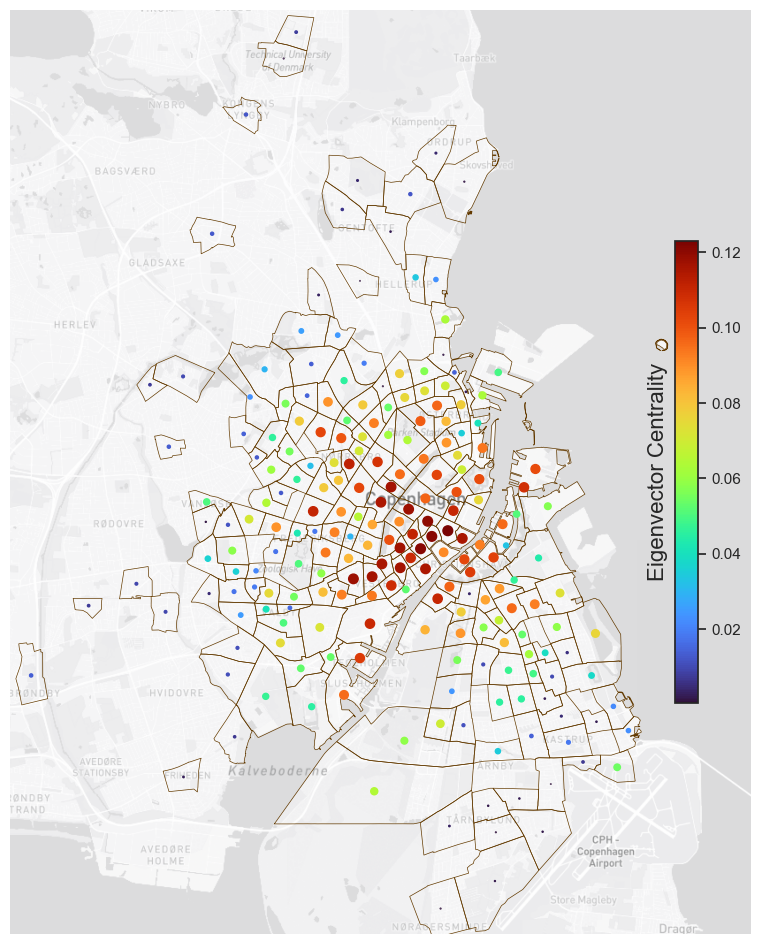

In [ ]:
# plot the network graph for bike trips with eigenvector centrality values
plot_network_graph(G_bike, cph_bikes_wm, pos_wm_bike, eigenvector_centrality_bike_list, eigenvector_centrality_bike_list, 
                   '', "Eigenvector Centrality",
                   t= 0.04, b=0.05, l=0.27, r=0.04, scale_factor=400)

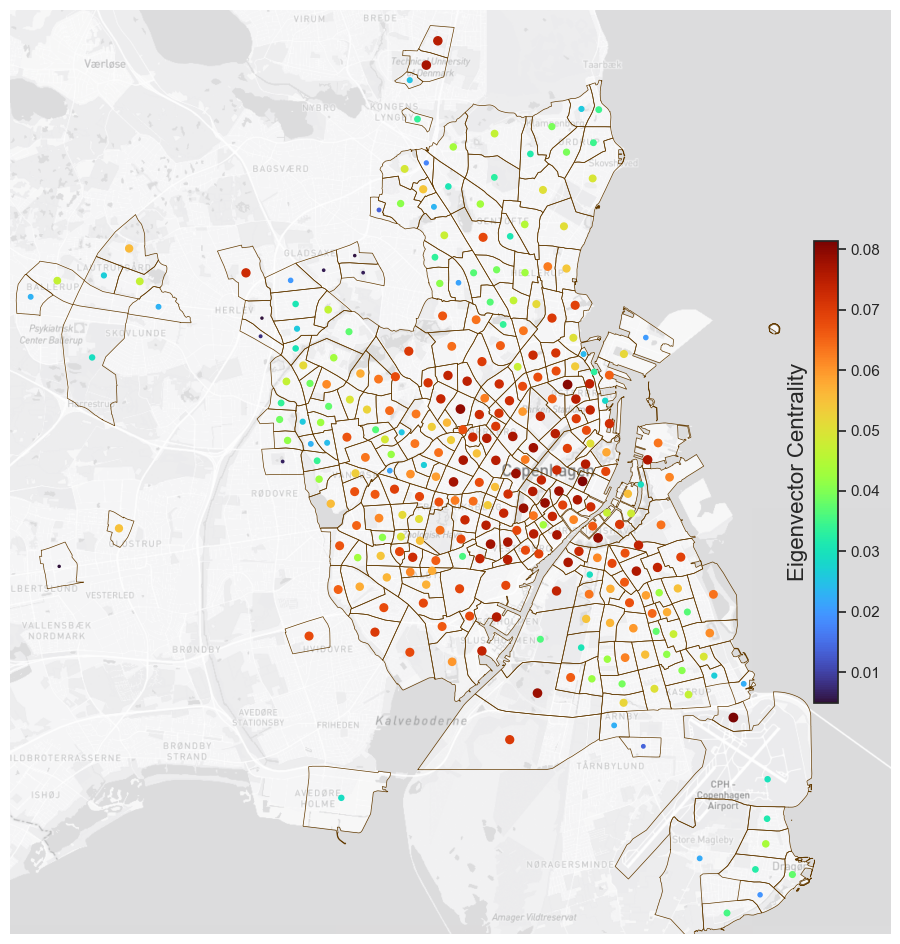

In [ ]:
# plot the network graph for car trips with eigenvector centrality values

plot_network_graph(G_car, cph_cars_wm, pos_wm, eigenvector_centrality_car_list, eigenvector_centrality_car_list,
                     '', "Eigenvector Centrality",
                     t= 0.03, b=0.05, l=0.18, r=0.19, scale_factor=450)

In [ ]:
current_flow_closeness_bike = nx.current_flow_closeness_centrality(G_bike.to_undirected(),weight = "TotalTrips")
# car current flow

current_flow_closeness_car = nx.current_flow_closeness_centrality(G_car.to_undirected(),weight = "TotalTrips")

# sort the nodes by their current flow closeness centrality to identify the ones with the highest current flow closeness centrality
sorted_current_flow_closeness_bike = sorted(current_flow_closeness_bike.items(), key=lambda x: x[1], reverse=True)
# sort the nodes by their current flow closeness centrality to identify the ones with the highest current flow closeness centrality
sorted_current_flow_closeness_car = sorted(current_flow_closeness_car.items(), key=lambda x: x[1], reverse=True)

# create list of current flow closeness centrality values
current_flow_closeness_bike_list = list(current_flow_closeness_bike.values())
# create list of current flow closeness centrality values
current_flow_closeness_car_list = list(current_flow_closeness_car.values())




In [ ]:
sorted_current_flow_closeness_car[:5]

[('Kastrup Lufthavn Udenrigs', 1.4680298229508608),
 ('Sydhavn Ø', 1.4387285320829557),
 ('DTU S', 1.4331905113685766),
 ('Dronningens Tværgade', 1.4253874663094193),
 ('Ørestaden Metrostation', 1.4131981799972622)]

In [ ]:
sorted_current_flow_closeness_bike[:5]

[('Gammelholm', 0.11914895058669887),
 ('Kgs. Nytorv', 0.11914244538212412),
 ('Rundetårn', 0.11910980939404185),
 ('Rådhuspladsen', 0.1190207205734329),
 ('Amagertorv', 0.11888463231443258)]

In [ ]:
# compute load centrality bike
load_centrality_bike = nx.load_centrality(G_bike, weight = "AvgDistanceKm")
# compute load centrality car
load_centrality_car = nx.load_centrality(G_car, weight = "AvgDistanceKm")

# sort the nodes by their load centrality to identify the ones with the highest load centrality
sorted_load_centrality_bike = sorted(load_centrality_bike.items(), key=lambda x: x[1], reverse=True)
# sort the nodes by their load centrality to identify the ones with the highest load centrality
sorted_load_centrality_car = sorted(load_centrality_car.items(), key=lambda x: x[1], reverse=True)

# create list of load centrality values
load_centrality_bike_list = list(load_centrality_bike.values())
# create list of load centrality values
load_centrality_car_list = list(load_centrality_car.values())


In [ ]:
sorted_load_centrality_car[:5]

[('Hellerup SV', 0.01461032293852254),
 ('Sundbyvester Ø', 0.014211746611473787),
 ('Frederiksberg Vest NØ N', 0.013654338252669424),
 ('Tivoli', 0.013499196450754173),
 ('Frederiksberg Øst Ø NV', 0.012199967272050397)]

In [ ]:
# compute voterank for bikes
voterank_bike = nx.voterank(G_bike, number_of_nodes=10)
# compute voterank for cars
voterank_car = nx.voterank(G_car, number_of_nodes=10)



In [ ]:
voterank_car

['Kastrup Lufthavn Udenrigs',
 'Dronningens Tværgade',
 'Vesterport Station V',
 'Pisserenden',
 'Rundetårn',
 'Kgs. Nytorv',
 'Indre Østerbro N',
 'Vesterbro N',
 'Indre Nørrebro NNØ',
 'Langebro N']

In [ ]:
# compute the global_efficiency centrality bike and car
global_efficiency_bike = nx.local_efficiency(G_bike.to_undirected())
global_efficiency_car = nx.local_efficiency(G_car.to_undirected())
global_efficiency_bike, global_efficiency_car


KeyboardInterrupt: 

In [ ]:
nx.global_efficiency(G_bike.to_undirected()), nx.global_efficiency(G_car.to_undirected())

(0.6689707176070797, 0.8479990383144275)

In [ ]:
# check if the graphs are strongly connected
nx.is_strongly_connected(G_bike), nx.is_strongly_connected(G_car)

(True, True)

In [ ]:
bike_avg_shortest_path = nx.average_shortest_path_length(G_bike, weight = "AvgDistanceKm", method='floyd-warshall')
car_avg_shortest_path = nx.average_shortest_path_length(G_car,  weight = "AvgDistanceKm", method='floyd-warshall')
bike_avg_shortest_path, car_avg_shortest_path

(5.456222235169055, 9.112674372917438)

In [ ]:
bike_avg_shortest_path = nx.average_shortest_path_length(G_bike,  )
car_avg_shortest_path = nx.average_shortest_path_length(G_car,  )
bike_avg_shortest_path, car_avg_shortest_path

(1.8280340161702484, 1.4088037942867135)

In [ ]:
from pyrosm import OSM, get_data

# Load the OSM dataset for Copenhagen
#osm = OSM(get_data("copenhagen"))

# Extracting cycling network
#cycling_network_nodes, cycling_network_edges = osm.get_network(network_type="cycling", nodes=True, )

In [ ]:
# Convert the network into a NetworkX graph
#G_cycle = osm.to_graph(cycling_network_nodes, cycling_network_edges, graph_type="networkx")
